# Recurrent Neural Network predicting price change

We will use Keras to be able to modify the layers.
Import modules.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


We will use a **Neural Recurrent Network** because it is able to learn the pattern of sequences as it has weights connected betweeen the sequence tokens and the input (xT) is multiplied with previou output (hT-1). There are several types of Recurrent Neural Networks: a simple RNN, a LSTM and GRU. We will consider a simple RNN and LSTM: RNN is a simpler version. A LSTM (Long short term memory) is more complex and are introducing 2 more gates. A 'forget' and a 'output' gate.

A Recurrent Neural Network takes sequences as input.
As target we will use the next price change in the sequence. 
However as it is more interesting to try to predict in what direction the price goes, we will use the encoded version of the price change. ***Positive and Negative***

## Load the dataset

In [5]:
dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

In [6]:
print(dailyChanges.columns)
print(dailyChanges.shape)

dailyChanges.head()

Index(['date', 'open', 'close', 'low', 'high', 'volume', 'change',
       'stability'],
      dtype='object')
(1510, 8)


,date,open,close,low,high,volume,change,stability
0,2011-01-03,47.020216,47.210714,46.740986,47.633616,6.460778e+06,-0.344929,0
1,2011-01-04,47.286887,46.866950,46.419376,47.517700,6.738886e+06,0.811473,1
2,2011-01-05,46.697300,47.126548,46.452693,47.410466,7.073876e+06,-0.913005,0
3,2011-01-06,47.153983,46.998321,46.591836,47.550025,7.430919e+06,0.237169,1
4,2011-01-07,47.091944,46.952507,46.439834,47.435790,7.579271e+06,0.259163,1


---
## Split the data

We need to split the data into x and y and hot encode y so it fits the Neural Network.
x needs to be a sequence of an arbitrary length (a length that would predict next price change)

We are defining a sequence function like the one defined in tutorial 9.

It is also important not to shuffle the data as the order is important for the sequences.

In [7]:

#Helper function defined in Tutorial 9.
#Parameters:
#seq_size is how long the size of the frame should be
#df is the dataframe object
def to_sequences(seq_size, df):
    x = []
    y = []
    changes = df.change.tolist() ##The x values
    stabilityLabel = df.stability.tolist() ##The labels
    for i in range(len(stabilityLabel)-SEQUENCE_SIZE-1):
        window = stabilityLabel[i:(i+SEQUENCE_SIZE)] #Get specified numbers of price changes into X
        after_window = stabilityLabel[i+SEQUENCE_SIZE]
        window = [[x] for x in window] #convert window to array for correct format for the RNN with 3d
        x.append(window)
        y.append(after_window)        
    return np.array(x),np.array(y) ##Convert normal list to numpy array for correct format

SEQUENCE_SIZE = 10
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)


print(X.shape)

##It might also be a good idea to transform the data so it has mean 0 and standard deviation 1 
#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?



(1499, 10, 1)


# Visualize X and y




first sequence:  [[0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]
first label:  0
second sequence:  [[1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]
second label:  1


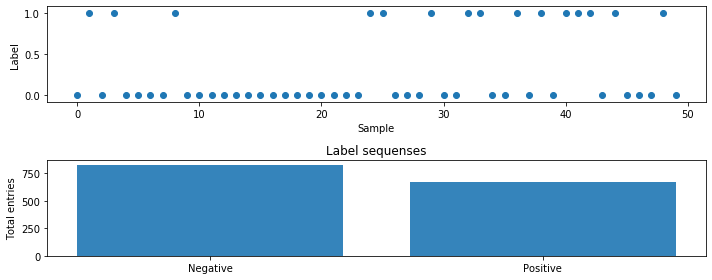

In [11]:
fig, axes = plt.subplots(2,1, figsize=(10,4))
axes[0].set_ylabel("Label")
axes[0].set_xlabel("Sample")
axes[0].scatter(np.arange(len(X[:50])),y[:50])



def plotStability(y, title):
    xLabels = ('Negative', 'Positive')
    yPos = np.arange(len(xLabels))
    yEntries = [0, 0]
    uniques = np.unique(y, return_counts=True) #Getting the counts of the labels as [[label1, label2],[count1, count2]]
    yEntries[0] = uniques[1][0]
    yEntries[1] = uniques[1][1]
    axes[1].bar(yPos, yEntries, align = 'center', alpha = 0.9)
    plt.xticks(yPos, xLabels)
    axes[1].set_ylabel("Total entries")
    axes[1].set_title(title, fontsize=15)
    
plotStability(y, title="Volatility distrubtuion")
plt.title("Label sequenses")
plt.tight_layout()


lenOfX = [len(x) for x in X]
print("first sequence: ",X[0])
print("first label: ",y[0])
print("second sequence: ",X[1])
print("second label: ",y[1])

***First figure is showing sequences and the RNN will try to predict an arbritary point in that figure by processing a sequence of earlier tokens.***

***

### One-Hot encode y and split data into training and test sets
We are using Keras to_categorical to get a hot encoding and Sklearn's train_test_split function with a 15 % test set. We are choosing a relativley low test set because we want to keep as much data in the training as possible.

In [182]:
y = to_categorical(y) #Hot encode it

##Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15)

print(X_train.shape)
print(X_train[0])
print(y_train[0]) #@{What's the significance of those outputs?}

(1274, 10, 1)
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[0. 1.]


***
# Set up the network and train it

We are using a Recurrent Neural Network which means that the output of the current timestep becomes input to the next timestep, allowing the ANN to have a memory.


#### Recurrent Neural Network Layers
***1.*** 
First RNN layer we are using is the SimpleRNN that comes with Keras. It is using a 
***Backpropogation through time (BPTT)***.
However, this method is subject to the vanishing gradient problem and therefore we will consider using LSTM that has been developed to address this problem. https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

***2.*** 
We will then compare it to a ***LSTM (Long Short Term Memory)***.
The time steps are then trainable and can choose to keep information depending on importance.
The LSTM layer has 3 gates. These gates are a "forget" gate for discarding information, an "input" gate for handling current input and a "output" gate for producing predictions for each time step. (https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)


#### input 3D [rows, timestep, columns]
We have 1 time step as we are shifting the sequence 1 step in every sample.



### Hyper parameters

#### Optimizer
We are using adam as optimizer. An optimizer improved from the classic Stochastic Gradient Descent.

      Adam was introduced 2015 by Diedrik Kingma from OpenAI
   
   ##### pros:
       Easy to implement
       computationally efficient
       Little memory requirments
       Invariant to diagonal rescale of the gradients
       Well suited for problems that are large in terms of data and/or paramters
       Appropiate for problems with very noisy and/or sparse gradients
       Hyper parameters have intuitive interpretation and typically require little tuning
       
   ##### Appicable to our problem:
       Adam combines two extensions of Stochastic Gradient. Normal stochastic gradient has the same learning rate for all weight updates which means it could fall into a local minimia or "overshoot" and never find the minima.
       
       
       Adam on the other hand maintains learning rate for each weight in the network. It does so by adapting the stochastic gradient extension (AdaGrad) that maintains a per-parameter learning rate that improves problems with sparse gradients. It also adapts Root mean square propogation 'RMSProp' that maintains a per-parameter learning rate that are changed based on the average of recent magnitude of the gradient which means the algorithm does well on online and non-stationary problems (e.g. noisy, which our data is).
        
       
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


****


#### Activation functions
We will use ReLU activation function in the hidden layers as it is also addressing the vanishing gradient problem by not squashing the input into a small region like, for example, sigmoid does. Instead it maps input space  : :x to max(0, x).

We will use softmax as activation function to get a probability for each label.
 $f(s)_{i} = \frac{e^{s_{i}}}{\sum_{j}^{C} e^{s_{j}}}$


#### Layers
As the decision boundary is difficult to guess we will test/try with different width and depth of the network. 

Something clear is that we have 3 nodes in the last layer and are using a softmax activation function to get a probability for every category. 


****


#### Loss function
The loss function to be optimized is **categorical crossentropy** as it is the choice for categorical classifications.

***

#### Batch size

The batch size of a neural network is the number of samples the network considers before updating its weights.
The weights will be updated after every epoch (batch learning). The smaller the batch, the faster the model will train, but the less accurate it becomes. **We will experiment with different batch sizes.**

****

#### Evaluation 
###### Accuarcy = Total correct / total
#### Precision for each label
#### Recall for each precsion 
###### ROC = Receiver operating characteristic curve (a.k.a ROC) is a graphic plot illustrating the diagnostic ability of its discrimination threshold.
###### AUC = Area Under the Curve is the percentage of the area that is under this ROC curve, ranging between 0~1.  

We will use a mix of all these evaluations in order to see how the classifier is performing.

***


# Simple RNN

First we run the model with initial settings for 1000 epochs to try to see where it converges.

## Let us see how well it fits the training data and generlizes at different epochs.

In [164]:
history = None

def create_and_run_RNN( ep, typeOfRnn="Simple", more_layers=False, withDropOut=False):
        model = Sequential()
        if typeOfRnn == "Simple":
            model.add(SimpleRNN(16, input_shape=(None, 1)))
        elif typeOfRnn == 'LSTM':
            model.add(LSTM(16, input_shape=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        if more_layers == True:
            model.add(Dense(8, activation='relu'))
          
            
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
     
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=7, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
       
   
        
        return history

model = create_and_run_RNN(1000) #Run with 20 epochs and the defauly RNN layer that is SimpleRNN

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_58 (SimpleRNN)    (None, 16)                288       
_________________________________________________________________
dense_207 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_208 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_209 (Dense)            (None, 2)                 18        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/1000
 - 2s - loss: 0.6905 - accuracy: 0.5369 - val_loss: 0.6964 - val_accuracy: 0.5644
Epoch 2/1000
 - 1s - loss: 0.6867 - accuracy: 0.5518 - val_loss: 0.6959 - val_accuracy: 0.5644
Epoch 3/1000
 - 

Epoch 77/1000
 - 1s - loss: 0.5744 - accuracy: 0.6970 - val_loss: 0.8025 - val_accuracy: 0.4978
Epoch 78/1000
 - 1s - loss: 0.5760 - accuracy: 0.6907 - val_loss: 0.7885 - val_accuracy: 0.5156
Epoch 79/1000
 - 1s - loss: 0.5755 - accuracy: 0.6915 - val_loss: 0.8132 - val_accuracy: 0.5067
Epoch 80/1000
 - 1s - loss: 0.5740 - accuracy: 0.6923 - val_loss: 0.8054 - val_accuracy: 0.5111
Epoch 81/1000
 - 1s - loss: 0.5726 - accuracy: 0.6954 - val_loss: 0.8007 - val_accuracy: 0.5200
Epoch 82/1000
 - 1s - loss: 0.5753 - accuracy: 0.6947 - val_loss: 0.7889 - val_accuracy: 0.5200
Epoch 83/1000
 - 1s - loss: 0.5713 - accuracy: 0.6970 - val_loss: 0.7869 - val_accuracy: 0.5333
Epoch 84/1000
 - 1s - loss: 0.5660 - accuracy: 0.7033 - val_loss: 0.8228 - val_accuracy: 0.5244
Epoch 85/1000
 - 1s - loss: 0.5657 - accuracy: 0.6994 - val_loss: 0.8168 - val_accuracy: 0.5200
Epoch 86/1000
 - 1s - loss: 0.5722 - accuracy: 0.6939 - val_loss: 0.8031 - val_accuracy: 0.5111
Epoch 87/1000
 - 1s - loss: 0.5696 - acc

Epoch 162/1000
 - 1s - loss: 0.5236 - accuracy: 0.7182 - val_loss: 0.9346 - val_accuracy: 0.5022
Epoch 163/1000
 - 1s - loss: 0.5209 - accuracy: 0.7292 - val_loss: 0.9142 - val_accuracy: 0.5378
Epoch 164/1000
 - 1s - loss: 0.5223 - accuracy: 0.7182 - val_loss: 0.9348 - val_accuracy: 0.5156
Epoch 165/1000
 - 1s - loss: 0.5225 - accuracy: 0.7174 - val_loss: 0.9369 - val_accuracy: 0.5022
Epoch 166/1000
 - 1s - loss: 0.5206 - accuracy: 0.7425 - val_loss: 0.9320 - val_accuracy: 0.5244
Epoch 167/1000
 - 1s - loss: 0.5182 - accuracy: 0.7268 - val_loss: 0.9425 - val_accuracy: 0.5067
Epoch 168/1000
 - 1s - loss: 0.5165 - accuracy: 0.7418 - val_loss: 0.9232 - val_accuracy: 0.5244
Epoch 169/1000
 - 1s - loss: 0.5179 - accuracy: 0.7339 - val_loss: 0.9072 - val_accuracy: 0.5333
Epoch 170/1000
 - 1s - loss: 0.5182 - accuracy: 0.7214 - val_loss: 0.9007 - val_accuracy: 0.5200
Epoch 171/1000
 - 1s - loss: 0.5158 - accuracy: 0.7363 - val_loss: 0.8862 - val_accuracy: 0.5511
Epoch 172/1000
 - 1s - loss: 0

Epoch 247/1000
 - 1s - loss: 0.4940 - accuracy: 0.7347 - val_loss: 0.9533 - val_accuracy: 0.5600
Epoch 248/1000
 - 1s - loss: 0.4931 - accuracy: 0.7488 - val_loss: 0.9816 - val_accuracy: 0.5422
Epoch 249/1000
 - 1s - loss: 0.5020 - accuracy: 0.7418 - val_loss: 0.9469 - val_accuracy: 0.5600
Epoch 250/1000
 - 1s - loss: 0.4927 - accuracy: 0.7402 - val_loss: 0.9942 - val_accuracy: 0.5289
Epoch 251/1000
 - 1s - loss: 0.4946 - accuracy: 0.7410 - val_loss: 1.0079 - val_accuracy: 0.5333
Epoch 252/1000
 - 1s - loss: 0.5025 - accuracy: 0.7425 - val_loss: 0.9755 - val_accuracy: 0.5067
Epoch 253/1000
 - 1s - loss: 0.4963 - accuracy: 0.7402 - val_loss: 0.9385 - val_accuracy: 0.5556
Epoch 254/1000
 - 1s - loss: 0.4988 - accuracy: 0.7363 - val_loss: 1.0038 - val_accuracy: 0.5200
Epoch 255/1000
 - 1s - loss: 0.5067 - accuracy: 0.7378 - val_loss: 0.9863 - val_accuracy: 0.4933
Epoch 256/1000
 - 1s - loss: 0.4970 - accuracy: 0.7214 - val_loss: 0.9931 - val_accuracy: 0.5156
Epoch 257/1000
 - 1s - loss: 0

Epoch 332/1000
 - 1s - loss: 0.4816 - accuracy: 0.7480 - val_loss: 1.0442 - val_accuracy: 0.5378
Epoch 333/1000
 - 1s - loss: 0.4825 - accuracy: 0.7402 - val_loss: 0.9684 - val_accuracy: 0.5511
Epoch 334/1000
 - 1s - loss: 0.4820 - accuracy: 0.7394 - val_loss: 1.0121 - val_accuracy: 0.5289
Epoch 335/1000
 - 1s - loss: 0.4794 - accuracy: 0.7520 - val_loss: 1.0789 - val_accuracy: 0.5333
Epoch 336/1000
 - 1s - loss: 0.4826 - accuracy: 0.7496 - val_loss: 1.0530 - val_accuracy: 0.5156
Epoch 337/1000
 - 1s - loss: 0.4822 - accuracy: 0.7496 - val_loss: 0.9712 - val_accuracy: 0.5200
Epoch 338/1000
 - 1s - loss: 0.4814 - accuracy: 0.7363 - val_loss: 1.0307 - val_accuracy: 0.5422
Epoch 339/1000
 - 1s - loss: 0.4809 - accuracy: 0.7496 - val_loss: 1.0030 - val_accuracy: 0.5156
Epoch 340/1000
 - 1s - loss: 0.4735 - accuracy: 0.7457 - val_loss: 1.0860 - val_accuracy: 0.5244
Epoch 341/1000
 - 1s - loss: 0.4828 - accuracy: 0.7425 - val_loss: 1.0585 - val_accuracy: 0.5333
Epoch 342/1000
 - 1s - loss: 0

Epoch 417/1000
 - 1s - loss: 0.4687 - accuracy: 0.7575 - val_loss: 1.0866 - val_accuracy: 0.5022
Epoch 418/1000
 - 1s - loss: 0.4798 - accuracy: 0.7441 - val_loss: 1.0765 - val_accuracy: 0.5111
Epoch 419/1000
 - 1s - loss: 0.4752 - accuracy: 0.7543 - val_loss: 1.0422 - val_accuracy: 0.5244
Epoch 420/1000
 - 1s - loss: 0.4762 - accuracy: 0.7441 - val_loss: 1.1040 - val_accuracy: 0.5022
Epoch 421/1000
 - 1s - loss: 0.4761 - accuracy: 0.7559 - val_loss: 1.0932 - val_accuracy: 0.5067
Epoch 422/1000
 - 1s - loss: 0.4742 - accuracy: 0.7504 - val_loss: 1.0406 - val_accuracy: 0.5289
Epoch 423/1000
 - 1s - loss: 0.4754 - accuracy: 0.7355 - val_loss: 1.0578 - val_accuracy: 0.5156
Epoch 424/1000
 - 2s - loss: 0.4813 - accuracy: 0.7473 - val_loss: 1.0983 - val_accuracy: 0.5200
Epoch 425/1000
 - 2s - loss: 0.4751 - accuracy: 0.7402 - val_loss: 1.0958 - val_accuracy: 0.5333
Epoch 426/1000
 - 1s - loss: 0.4766 - accuracy: 0.7410 - val_loss: 1.1350 - val_accuracy: 0.5067
Epoch 427/1000
 - 1s - loss: 0

Epoch 502/1000
 - 1s - loss: 0.4619 - accuracy: 0.7535 - val_loss: 1.1158 - val_accuracy: 0.5200
Epoch 503/1000
 - 1s - loss: 0.4672 - accuracy: 0.7551 - val_loss: 1.0673 - val_accuracy: 0.5422
Epoch 504/1000
 - 1s - loss: 0.4766 - accuracy: 0.7363 - val_loss: 1.1082 - val_accuracy: 0.5111
Epoch 505/1000
 - 1s - loss: 0.4731 - accuracy: 0.7480 - val_loss: 1.1372 - val_accuracy: 0.5022
Epoch 506/1000
 - 1s - loss: 0.4756 - accuracy: 0.7418 - val_loss: 1.1303 - val_accuracy: 0.5022
Epoch 507/1000
 - 1s - loss: 0.4645 - accuracy: 0.7473 - val_loss: 1.0905 - val_accuracy: 0.5289
Epoch 508/1000
 - 1s - loss: 0.4771 - accuracy: 0.7496 - val_loss: 1.0870 - val_accuracy: 0.5156
Epoch 509/1000
 - 1s - loss: 0.4638 - accuracy: 0.7496 - val_loss: 1.0983 - val_accuracy: 0.5022
Epoch 510/1000
 - 1s - loss: 0.4691 - accuracy: 0.7465 - val_loss: 1.1282 - val_accuracy: 0.5333
Epoch 511/1000
 - 1s - loss: 0.4695 - accuracy: 0.7496 - val_loss: 1.1730 - val_accuracy: 0.4889
Epoch 512/1000
 - 1s - loss: 0

Epoch 587/1000
 - 1s - loss: 0.4551 - accuracy: 0.7606 - val_loss: 1.1450 - val_accuracy: 0.5467
Epoch 588/1000
 - 1s - loss: 0.4575 - accuracy: 0.7622 - val_loss: 1.1873 - val_accuracy: 0.5378
Epoch 589/1000
 - 1s - loss: 0.4579 - accuracy: 0.7496 - val_loss: 1.1418 - val_accuracy: 0.4844
Epoch 590/1000
 - 1s - loss: 0.4590 - accuracy: 0.7543 - val_loss: 1.1249 - val_accuracy: 0.5378
Epoch 591/1000
 - 1s - loss: 0.4630 - accuracy: 0.7551 - val_loss: 1.1000 - val_accuracy: 0.5200
Epoch 592/1000
 - 1s - loss: 0.4638 - accuracy: 0.7567 - val_loss: 1.1814 - val_accuracy: 0.5022
Epoch 593/1000
 - 1s - loss: 0.4628 - accuracy: 0.7575 - val_loss: 1.1973 - val_accuracy: 0.5156
Epoch 594/1000
 - 1s - loss: 0.4572 - accuracy: 0.7520 - val_loss: 1.2138 - val_accuracy: 0.4889
Epoch 595/1000
 - 1s - loss: 0.4613 - accuracy: 0.7473 - val_loss: 1.1825 - val_accuracy: 0.5156
Epoch 596/1000
 - 1s - loss: 0.4599 - accuracy: 0.7457 - val_loss: 1.1553 - val_accuracy: 0.5200
Epoch 597/1000
 - 1s - loss: 0

Epoch 672/1000
 - 1s - loss: 0.4503 - accuracy: 0.7582 - val_loss: 1.2183 - val_accuracy: 0.4889
Epoch 673/1000
 - 1s - loss: 0.4508 - accuracy: 0.7606 - val_loss: 1.2502 - val_accuracy: 0.5111
Epoch 674/1000
 - 1s - loss: 0.4536 - accuracy: 0.7520 - val_loss: 1.2411 - val_accuracy: 0.5244
Epoch 675/1000
 - 1s - loss: 0.4525 - accuracy: 0.7551 - val_loss: 1.2458 - val_accuracy: 0.5111
Epoch 676/1000
 - 1s - loss: 0.4468 - accuracy: 0.7637 - val_loss: 1.2011 - val_accuracy: 0.5244
Epoch 677/1000
 - 1s - loss: 0.4602 - accuracy: 0.7543 - val_loss: 1.2581 - val_accuracy: 0.5067
Epoch 678/1000
 - 1s - loss: 0.4505 - accuracy: 0.7520 - val_loss: 1.2287 - val_accuracy: 0.5022
Epoch 679/1000
 - 1s - loss: 0.4588 - accuracy: 0.7488 - val_loss: 1.2576 - val_accuracy: 0.4978
Epoch 680/1000
 - 1s - loss: 0.4497 - accuracy: 0.7575 - val_loss: 1.2531 - val_accuracy: 0.5289
Epoch 681/1000
 - 1s - loss: 0.4564 - accuracy: 0.7559 - val_loss: 1.2254 - val_accuracy: 0.5111
Epoch 682/1000
 - 1s - loss: 0

Epoch 757/1000
 - 1s - loss: 0.4527 - accuracy: 0.7567 - val_loss: 1.2416 - val_accuracy: 0.5067
Epoch 758/1000
 - 1s - loss: 0.4498 - accuracy: 0.7653 - val_loss: 1.2819 - val_accuracy: 0.5156
Epoch 759/1000
 - 1s - loss: 0.4531 - accuracy: 0.7457 - val_loss: 1.2374 - val_accuracy: 0.5111
Epoch 760/1000
 - 1s - loss: 0.4555 - accuracy: 0.7527 - val_loss: 1.2588 - val_accuracy: 0.5022
Epoch 761/1000
 - 1s - loss: 0.4485 - accuracy: 0.7559 - val_loss: 1.2685 - val_accuracy: 0.5022
Epoch 762/1000
 - 1s - loss: 0.4440 - accuracy: 0.7630 - val_loss: 1.2830 - val_accuracy: 0.4933
Epoch 763/1000
 - 1s - loss: 0.4551 - accuracy: 0.7551 - val_loss: 1.2654 - val_accuracy: 0.4844
Epoch 764/1000
 - 1s - loss: 0.4483 - accuracy: 0.7575 - val_loss: 1.2455 - val_accuracy: 0.5200
Epoch 765/1000
 - 1s - loss: 0.4511 - accuracy: 0.7614 - val_loss: 1.2685 - val_accuracy: 0.5111
Epoch 766/1000
 - 1s - loss: 0.4459 - accuracy: 0.7590 - val_loss: 1.2795 - val_accuracy: 0.5289
Epoch 767/1000
 - 1s - loss: 0

Epoch 842/1000
 - 1s - loss: 0.4500 - accuracy: 0.7653 - val_loss: 1.2939 - val_accuracy: 0.5022
Epoch 843/1000
 - 1s - loss: 0.4455 - accuracy: 0.7551 - val_loss: 1.3229 - val_accuracy: 0.5156
Epoch 844/1000
 - 1s - loss: 0.4475 - accuracy: 0.7535 - val_loss: 1.2736 - val_accuracy: 0.5067
Epoch 845/1000
 - 1s - loss: 0.4453 - accuracy: 0.7559 - val_loss: 1.2703 - val_accuracy: 0.5378
Epoch 846/1000
 - 1s - loss: 0.4490 - accuracy: 0.7480 - val_loss: 1.2869 - val_accuracy: 0.5067
Epoch 847/1000
 - 1s - loss: 0.4551 - accuracy: 0.7457 - val_loss: 1.2676 - val_accuracy: 0.5200
Epoch 848/1000
 - 1s - loss: 0.4482 - accuracy: 0.7520 - val_loss: 1.2732 - val_accuracy: 0.5111
Epoch 849/1000
 - 1s - loss: 0.4503 - accuracy: 0.7527 - val_loss: 1.2912 - val_accuracy: 0.4933
Epoch 850/1000
 - 1s - loss: 0.4558 - accuracy: 0.7567 - val_loss: 1.2628 - val_accuracy: 0.5111
Epoch 851/1000
 - 1s - loss: 0.4381 - accuracy: 0.7645 - val_loss: 1.2848 - val_accuracy: 0.4978
Epoch 852/1000
 - 1s - loss: 0

Epoch 927/1000
 - 1s - loss: 0.4442 - accuracy: 0.7527 - val_loss: 1.3367 - val_accuracy: 0.4978
Epoch 928/1000
 - 1s - loss: 0.4433 - accuracy: 0.7598 - val_loss: 1.3077 - val_accuracy: 0.4933
Epoch 929/1000
 - 1s - loss: 0.4472 - accuracy: 0.7520 - val_loss: 1.3328 - val_accuracy: 0.5156
Epoch 930/1000
 - 1s - loss: 0.4483 - accuracy: 0.7614 - val_loss: 1.2938 - val_accuracy: 0.5111
Epoch 931/1000
 - 1s - loss: 0.4468 - accuracy: 0.7598 - val_loss: 1.2891 - val_accuracy: 0.5156
Epoch 932/1000
 - 1s - loss: 0.4546 - accuracy: 0.7535 - val_loss: 1.3192 - val_accuracy: 0.5111
Epoch 933/1000
 - 1s - loss: 0.4394 - accuracy: 0.7551 - val_loss: 1.2648 - val_accuracy: 0.5022
Epoch 934/1000
 - 1s - loss: 0.4638 - accuracy: 0.7535 - val_loss: 1.2962 - val_accuracy: 0.4800
Epoch 935/1000
 - 1s - loss: 0.4415 - accuracy: 0.7606 - val_loss: 1.2994 - val_accuracy: 0.5200
Epoch 936/1000
 - 1s - loss: 0.4471 - accuracy: 0.7527 - val_loss: 1.3116 - val_accuracy: 0.5067
Epoch 937/1000
 - 1s - loss: 0

## Evaluate performance metrics on validation set and training set

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Training loss/ Accuracy    

def evaluate_mode(model):

    plt.figure()
    plt.plot(model.history['loss'])
    plt.title('Model loss/accuracy - training', fontsize=18)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper left')
    plt2=plt.twinx()
    color = 'red'
    plt2.plot(model.history['accuracy'],color=color)
    plt.ylabel('Accuracy')
    plt2.legend(['Accuracy'], loc='upper center')
    plt.show()


    plt.figure()
    
        
    y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
    pred = [np.argmax(x) for x in model.pred] #ecode from one-hot encoding
    
    ##Confusion amtrix
    cm = confusion_matrix(y_compare, pred) ##For evaluation later
    normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
 
    

            
    plt.figure(figsize=(5,5))
    #Show confion matrix for last epoch 
    plt.title("Confusion matrix", fontsize=18)
    ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
    ax.set_ylim(3,0) #maked heatmap showiung all squares
    plt.xlabel('predicted value', fontsize=15)
    plt.ylabel('true value',  fontsize=15);
    
    
    ##Normalized confusion matrix
    plt.figure(figsize=(5,5))
    #Show confion matrix for last epoch 
    plt.title("Normalized Confusion matrix", fontsize=18)
    ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
    ax.set_ylim(3,0) #maked heatmap showiung all squares
    plt.xlabel('predicted value', fontsize=15)
    plt.ylabel('true value',  fontsize=15);

        
    plt.figure()
    ### Validation loss/ Accuracy 
    plt.plot(model.history['val_loss'])
    plt.title('Model loss/accuracy - validation', fontsize=18)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper left')
    plt2=plt.twinx()
    color = 'red'
    plt2.plot(model.history['val_accuracy'],color=color)
    plt.ylabel('Accuracy')
    plt2.legend(['Accuracy'], loc='upper center')
    plt.show()

    ##Examine the probability distrubtion of the softmax output
    np.set_printoptions(suppress=True)

 
    print(classification_report(y_compare, pred))
    
    
    #Plot the ROC and AUC
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), model.pred.ravel())
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')


evaluate_mode(model)


NameError: name 'model' is not defined

The recall is telling us that the model is more biased to classify a value as a negative. Here we were experimenting with different sequence sizes. The code for that can be found in the very end of this notebook. We found out that a sequence of 5 tokens was underfitting.

***
## LSTM (Long short term memory)

LSMT with its 2 extra gates (update, output) has 2 more weight sets which implies there will be a larger amount of parameters to train in the first Recurrent layer.

In [185]:
model = create_and_run_RNN(1000, typeOfRnn="LSTM" ) 

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_232 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_233 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_234 (Dense)            (None, 2)                 18        
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/1000
 - 3s - loss: 0.6895 - accuracy: 0.5463 - val_loss: 0.6769 - val_accuracy: 0.5956
Epoch 2/1000
 - 1s - loss: 0.6901 - accuracy: 0.5471 - val_loss: 0.6797 - val_accuracy: 0.5956
Epoch 3/1000

Epoch 77/1000
 - 1s - loss: 0.6669 - accuracy: 0.5746 - val_loss: 0.7025 - val_accuracy: 0.5289
Epoch 78/1000
 - 1s - loss: 0.6674 - accuracy: 0.5895 - val_loss: 0.7013 - val_accuracy: 0.5111
Epoch 79/1000
 - 1s - loss: 0.6685 - accuracy: 0.5801 - val_loss: 0.7017 - val_accuracy: 0.4978
Epoch 80/1000
 - 1s - loss: 0.6675 - accuracy: 0.5934 - val_loss: 0.7013 - val_accuracy: 0.5289
Epoch 81/1000
 - 1s - loss: 0.6643 - accuracy: 0.5950 - val_loss: 0.7074 - val_accuracy: 0.5022
Epoch 82/1000
 - 1s - loss: 0.6645 - accuracy: 0.5903 - val_loss: 0.7017 - val_accuracy: 0.5111
Epoch 83/1000
 - 1s - loss: 0.6628 - accuracy: 0.5965 - val_loss: 0.7072 - val_accuracy: 0.5244
Epoch 84/1000
 - 1s - loss: 0.6646 - accuracy: 0.5777 - val_loss: 0.7050 - val_accuracy: 0.4978
Epoch 85/1000
 - 1s - loss: 0.6639 - accuracy: 0.5997 - val_loss: 0.7051 - val_accuracy: 0.4978
Epoch 86/1000
 - 1s - loss: 0.6658 - accuracy: 0.5871 - val_loss: 0.7040 - val_accuracy: 0.5067
Epoch 87/1000
 - 1s - loss: 0.6632 - acc

Epoch 162/1000
 - 1s - loss: 0.6373 - accuracy: 0.6209 - val_loss: 0.7493 - val_accuracy: 0.4800
Epoch 163/1000
 - 1s - loss: 0.6388 - accuracy: 0.6279 - val_loss: 0.7426 - val_accuracy: 0.5111
Epoch 164/1000
 - 1s - loss: 0.6390 - accuracy: 0.6272 - val_loss: 0.7457 - val_accuracy: 0.4756
Epoch 165/1000
 - 1s - loss: 0.6393 - accuracy: 0.6366 - val_loss: 0.7472 - val_accuracy: 0.4756
Epoch 166/1000
 - 1s - loss: 0.6351 - accuracy: 0.6327 - val_loss: 0.7512 - val_accuracy: 0.5022
Epoch 167/1000
 - 1s - loss: 0.6347 - accuracy: 0.6444 - val_loss: 0.7581 - val_accuracy: 0.5111
Epoch 168/1000
 - 1s - loss: 0.6348 - accuracy: 0.6311 - val_loss: 0.7468 - val_accuracy: 0.4667
Epoch 169/1000
 - 1s - loss: 0.6324 - accuracy: 0.6381 - val_loss: 0.7579 - val_accuracy: 0.4800
Epoch 170/1000
 - 1s - loss: 0.6350 - accuracy: 0.6319 - val_loss: 0.7388 - val_accuracy: 0.4978
Epoch 171/1000
 - 1s - loss: 0.6379 - accuracy: 0.6287 - val_loss: 0.7510 - val_accuracy: 0.4800
Epoch 172/1000
 - 1s - loss: 0

Epoch 247/1000
 - 1s - loss: 0.5968 - accuracy: 0.6743 - val_loss: 0.8269 - val_accuracy: 0.4622
Epoch 248/1000
 - 1s - loss: 0.6117 - accuracy: 0.6656 - val_loss: 0.8108 - val_accuracy: 0.4933
Epoch 249/1000
 - 1s - loss: 0.5974 - accuracy: 0.6641 - val_loss: 0.7984 - val_accuracy: 0.4933
Epoch 250/1000
 - 1s - loss: 0.5992 - accuracy: 0.6727 - val_loss: 0.8014 - val_accuracy: 0.4844
Epoch 251/1000
 - 1s - loss: 0.5995 - accuracy: 0.6719 - val_loss: 0.7861 - val_accuracy: 0.5022
Epoch 252/1000
 - 1s - loss: 0.5965 - accuracy: 0.6766 - val_loss: 0.7968 - val_accuracy: 0.4978
Epoch 253/1000
 - 1s - loss: 0.5973 - accuracy: 0.6782 - val_loss: 0.8059 - val_accuracy: 0.5022
Epoch 254/1000
 - 1s - loss: 0.5953 - accuracy: 0.6719 - val_loss: 0.8176 - val_accuracy: 0.4889
Epoch 255/1000
 - 1s - loss: 0.5926 - accuracy: 0.6821 - val_loss: 0.8162 - val_accuracy: 0.4889
Epoch 256/1000
 - 1s - loss: 0.5937 - accuracy: 0.6797 - val_loss: 0.8050 - val_accuracy: 0.5289
Epoch 257/1000
 - 1s - loss: 0

Epoch 332/1000
 - 1s - loss: 0.5737 - accuracy: 0.6970 - val_loss: 0.8463 - val_accuracy: 0.5289
Epoch 333/1000
 - 1s - loss: 0.5684 - accuracy: 0.6900 - val_loss: 0.8431 - val_accuracy: 0.4844
Epoch 334/1000
 - 1s - loss: 0.5773 - accuracy: 0.6884 - val_loss: 0.8087 - val_accuracy: 0.5156
Epoch 335/1000
 - 1s - loss: 0.5669 - accuracy: 0.7002 - val_loss: 0.8387 - val_accuracy: 0.4933
Epoch 336/1000
 - 1s - loss: 0.5721 - accuracy: 0.6939 - val_loss: 0.8268 - val_accuracy: 0.5111
Epoch 337/1000
 - 1s - loss: 0.5731 - accuracy: 0.6978 - val_loss: 0.8324 - val_accuracy: 0.5022
Epoch 338/1000
 - 1s - loss: 0.5684 - accuracy: 0.7041 - val_loss: 0.8525 - val_accuracy: 0.5022
Epoch 339/1000
 - 1s - loss: 0.5752 - accuracy: 0.6868 - val_loss: 0.8621 - val_accuracy: 0.4933
Epoch 340/1000
 - 1s - loss: 0.5656 - accuracy: 0.6994 - val_loss: 0.8716 - val_accuracy: 0.5244
Epoch 341/1000
 - 1s - loss: 0.5657 - accuracy: 0.6986 - val_loss: 0.8609 - val_accuracy: 0.5156
Epoch 342/1000
 - 1s - loss: 0

Epoch 417/1000
 - 1s - loss: 0.5418 - accuracy: 0.7002 - val_loss: 0.9090 - val_accuracy: 0.5022
Epoch 418/1000
 - 1s - loss: 0.5457 - accuracy: 0.7111 - val_loss: 0.9012 - val_accuracy: 0.4889
Epoch 419/1000
 - 1s - loss: 0.5466 - accuracy: 0.7096 - val_loss: 0.8755 - val_accuracy: 0.5200
Epoch 420/1000
 - 1s - loss: 0.5417 - accuracy: 0.7057 - val_loss: 0.9008 - val_accuracy: 0.4978
Epoch 421/1000
 - 1s - loss: 0.5419 - accuracy: 0.7111 - val_loss: 0.9345 - val_accuracy: 0.5111
Epoch 422/1000
 - 1s - loss: 0.5402 - accuracy: 0.7041 - val_loss: 0.9004 - val_accuracy: 0.5022
Epoch 423/1000
 - 1s - loss: 0.5417 - accuracy: 0.7088 - val_loss: 0.9020 - val_accuracy: 0.5244
Epoch 424/1000
 - 1s - loss: 0.5391 - accuracy: 0.7096 - val_loss: 0.8817 - val_accuracy: 0.5422
Epoch 425/1000
 - 1s - loss: 0.5387 - accuracy: 0.7237 - val_loss: 0.8863 - val_accuracy: 0.5111
Epoch 426/1000
 - 1s - loss: 0.5377 - accuracy: 0.7182 - val_loss: 0.9139 - val_accuracy: 0.4933
Epoch 427/1000
 - 1s - loss: 0

Epoch 502/1000
 - 1s - loss: 0.5200 - accuracy: 0.7237 - val_loss: 0.9624 - val_accuracy: 0.5378
Epoch 503/1000
 - 1s - loss: 0.5142 - accuracy: 0.7229 - val_loss: 0.9604 - val_accuracy: 0.5378
Epoch 504/1000
 - 1s - loss: 0.5118 - accuracy: 0.7174 - val_loss: 0.9411 - val_accuracy: 0.5467
Epoch 505/1000
 - 1s - loss: 0.5200 - accuracy: 0.7276 - val_loss: 0.9464 - val_accuracy: 0.5156
Epoch 506/1000
 - 1s - loss: 0.5149 - accuracy: 0.7237 - val_loss: 0.9643 - val_accuracy: 0.5422
Epoch 507/1000
 - 1s - loss: 0.5134 - accuracy: 0.7300 - val_loss: 0.9241 - val_accuracy: 0.5467
Epoch 508/1000
 - 1s - loss: 0.5126 - accuracy: 0.7308 - val_loss: 0.9304 - val_accuracy: 0.5333
Epoch 509/1000
 - 1s - loss: 0.5113 - accuracy: 0.7159 - val_loss: 0.9243 - val_accuracy: 0.5556
Epoch 510/1000
 - 1s - loss: 0.5114 - accuracy: 0.7276 - val_loss: 0.9309 - val_accuracy: 0.5422
Epoch 511/1000
 - 1s - loss: 0.5183 - accuracy: 0.7300 - val_loss: 0.9571 - val_accuracy: 0.5600
Epoch 512/1000
 - 1s - loss: 0

Epoch 587/1000
 - 1s - loss: 0.5025 - accuracy: 0.7300 - val_loss: 1.0224 - val_accuracy: 0.5378
Epoch 588/1000
 - 1s - loss: 0.4965 - accuracy: 0.7418 - val_loss: 1.0196 - val_accuracy: 0.5289
Epoch 589/1000
 - 1s - loss: 0.4961 - accuracy: 0.7363 - val_loss: 1.0211 - val_accuracy: 0.5467
Epoch 590/1000
 - 1s - loss: 0.4952 - accuracy: 0.7394 - val_loss: 1.0271 - val_accuracy: 0.5244
Epoch 591/1000
 - 1s - loss: 0.4920 - accuracy: 0.7339 - val_loss: 1.0246 - val_accuracy: 0.5333
Epoch 592/1000
 - 1s - loss: 0.5007 - accuracy: 0.7331 - val_loss: 1.0502 - val_accuracy: 0.4978
Epoch 593/1000
 - 1s - loss: 0.4957 - accuracy: 0.7316 - val_loss: 1.0253 - val_accuracy: 0.5333
Epoch 594/1000
 - 1s - loss: 0.4991 - accuracy: 0.7394 - val_loss: 1.0050 - val_accuracy: 0.5333
Epoch 595/1000
 - 1s - loss: 0.4934 - accuracy: 0.7480 - val_loss: 0.9965 - val_accuracy: 0.5289
Epoch 596/1000
 - 1s - loss: 0.4995 - accuracy: 0.7370 - val_loss: 0.9776 - val_accuracy: 0.5333
Epoch 597/1000
 - 1s - loss: 0

Epoch 672/1000
 - 1s - loss: 0.4831 - accuracy: 0.7504 - val_loss: 1.0443 - val_accuracy: 0.5422
Epoch 673/1000
 - 1s - loss: 0.4773 - accuracy: 0.7425 - val_loss: 1.0635 - val_accuracy: 0.5556
Epoch 674/1000
 - 1s - loss: 0.4719 - accuracy: 0.7598 - val_loss: 1.0460 - val_accuracy: 0.5333
Epoch 675/1000
 - 1s - loss: 0.4784 - accuracy: 0.7457 - val_loss: 1.0483 - val_accuracy: 0.5556
Epoch 676/1000
 - 1s - loss: 0.4756 - accuracy: 0.7488 - val_loss: 1.0915 - val_accuracy: 0.5244
Epoch 677/1000
 - 1s - loss: 0.4817 - accuracy: 0.7465 - val_loss: 1.0198 - val_accuracy: 0.5378
Epoch 678/1000
 - 1s - loss: 0.4725 - accuracy: 0.7473 - val_loss: 1.0206 - val_accuracy: 0.5378
Epoch 679/1000
 - 1s - loss: 0.4793 - accuracy: 0.7496 - val_loss: 1.1037 - val_accuracy: 0.5200
Epoch 680/1000
 - 1s - loss: 0.4803 - accuracy: 0.7449 - val_loss: 1.0431 - val_accuracy: 0.5467
Epoch 681/1000
 - 1s - loss: 0.4716 - accuracy: 0.7449 - val_loss: 1.0450 - val_accuracy: 0.5511
Epoch 682/1000
 - 1s - loss: 0

Epoch 757/1000
 - 1s - loss: 0.4655 - accuracy: 0.7567 - val_loss: 1.0878 - val_accuracy: 0.5333
Epoch 758/1000
 - 1s - loss: 0.4612 - accuracy: 0.7630 - val_loss: 1.1256 - val_accuracy: 0.5511
Epoch 759/1000
 - 1s - loss: 0.4720 - accuracy: 0.7512 - val_loss: 1.0626 - val_accuracy: 0.5289
Epoch 760/1000
 - 1s - loss: 0.4626 - accuracy: 0.7559 - val_loss: 1.1311 - val_accuracy: 0.5200
Epoch 761/1000
 - 1s - loss: 0.4654 - accuracy: 0.7582 - val_loss: 1.1038 - val_accuracy: 0.5022
Epoch 762/1000
 - 1s - loss: 0.4650 - accuracy: 0.7543 - val_loss: 1.1199 - val_accuracy: 0.5244
Epoch 763/1000
 - 1s - loss: 0.4588 - accuracy: 0.7606 - val_loss: 1.1229 - val_accuracy: 0.5289
Epoch 764/1000
 - 1s - loss: 0.4643 - accuracy: 0.7496 - val_loss: 1.0983 - val_accuracy: 0.5333
Epoch 765/1000
 - 1s - loss: 0.4617 - accuracy: 0.7410 - val_loss: 1.0998 - val_accuracy: 0.5067
Epoch 766/1000
 - 1s - loss: 0.4607 - accuracy: 0.7622 - val_loss: 1.0882 - val_accuracy: 0.5333
Epoch 767/1000
 - 1s - loss: 0

Epoch 842/1000
 - 1s - loss: 0.4534 - accuracy: 0.7575 - val_loss: 1.1155 - val_accuracy: 0.5244
Epoch 843/1000
 - 1s - loss: 0.4524 - accuracy: 0.7543 - val_loss: 1.1184 - val_accuracy: 0.5244
Epoch 844/1000
 - 1s - loss: 0.4566 - accuracy: 0.7645 - val_loss: 1.1474 - val_accuracy: 0.5156
Epoch 845/1000
 - 1s - loss: 0.4511 - accuracy: 0.7551 - val_loss: 1.1755 - val_accuracy: 0.5200
Epoch 846/1000
 - 1s - loss: 0.4462 - accuracy: 0.7543 - val_loss: 1.1418 - val_accuracy: 0.5378
Epoch 847/1000
 - 1s - loss: 0.4514 - accuracy: 0.7708 - val_loss: 1.1520 - val_accuracy: 0.5467
Epoch 848/1000
 - 1s - loss: 0.4553 - accuracy: 0.7590 - val_loss: 1.1334 - val_accuracy: 0.5200
Epoch 849/1000
 - 1s - loss: 0.4548 - accuracy: 0.7606 - val_loss: 1.1793 - val_accuracy: 0.5289
Epoch 850/1000
 - 1s - loss: 0.4504 - accuracy: 0.7551 - val_loss: 1.1825 - val_accuracy: 0.5333
Epoch 851/1000
 - 1s - loss: 0.4534 - accuracy: 0.7480 - val_loss: 1.1636 - val_accuracy: 0.5111
Epoch 852/1000
 - 1s - loss: 0

Epoch 927/1000
 - 1s - loss: 0.4454 - accuracy: 0.7575 - val_loss: 1.2013 - val_accuracy: 0.4978
Epoch 928/1000
 - 1s - loss: 0.4418 - accuracy: 0.7653 - val_loss: 1.1592 - val_accuracy: 0.5244
Epoch 929/1000
 - 1s - loss: 0.4375 - accuracy: 0.7630 - val_loss: 1.1663 - val_accuracy: 0.5200
Epoch 930/1000
 - 1s - loss: 0.4457 - accuracy: 0.7551 - val_loss: 1.1965 - val_accuracy: 0.4978
Epoch 931/1000
 - 1s - loss: 0.4402 - accuracy: 0.7669 - val_loss: 1.2190 - val_accuracy: 0.5111
Epoch 932/1000
 - 1s - loss: 0.4388 - accuracy: 0.7637 - val_loss: 1.1507 - val_accuracy: 0.5289
Epoch 933/1000
 - 1s - loss: 0.4378 - accuracy: 0.7512 - val_loss: 1.1598 - val_accuracy: 0.5289
Epoch 934/1000
 - 1s - loss: 0.4412 - accuracy: 0.7622 - val_loss: 1.1761 - val_accuracy: 0.5156
Epoch 935/1000
 - 1s - loss: 0.4394 - accuracy: 0.7543 - val_loss: 1.1730 - val_accuracy: 0.5022
Epoch 936/1000
 - 1s - loss: 0.4495 - accuracy: 0.7645 - val_loss: 1.1795 - val_accuracy: 0.5200
Epoch 937/1000
 - 1s - loss: 0

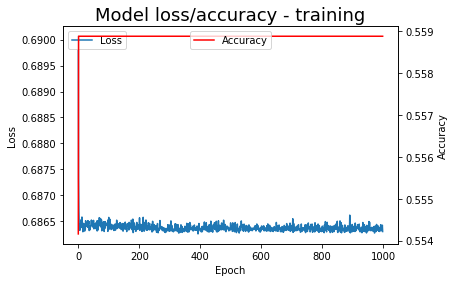

<Figure size 432x288 with 0 Axes>

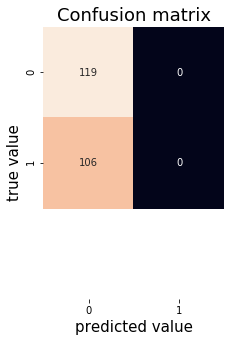

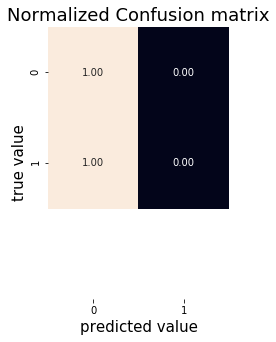

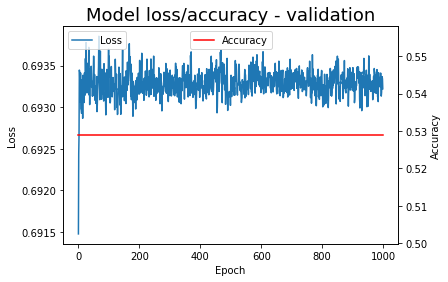

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       119
           1       0.00      0.00      0.00       106

    accuracy                           0.53       225
   macro avg       0.26      0.50      0.35       225
weighted avg       0.28      0.53      0.37       225



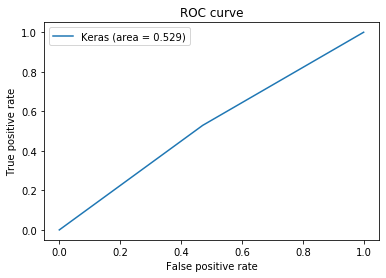

In [160]:
evaluate_mode(model)

***
## More layers, lower batch size and more neurons.


In [168]:
history = None

def create_and_run_RNN_more_layers(ep):
        model = Sequential()
       
        model.add(SimpleRNN(16, input_shape=(None, 1)))
        model.add(SimpleRNN(32, input_shape=(None, 1)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
  #     model.add(Dense(8, activation='relu'))
        #model.add(Dense(8, activation='relu'))
        #model.add(Dense(8, activation='relu'))
   
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
       
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=15, validation_data=(X_test,y_test)) ##Fit the data
        #history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
        #history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data

    
    
    
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
       
   
        
        return history



In [169]:
model = create_and_run_RNN_more_layers(1000 ) 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_59 (SimpleRNN)    (None, 16)                288       
_________________________________________________________________
dense_210 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_211 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_212 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_213 (Dense)            (None, 2)                 18        
Total params: 586
Trainable params: 586
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/1000
 - 2s - loss: 0.6963 - accuracy: 0.5228 - val_loss: 0.6894 - 

Epoch 76/1000
 - 0s - loss: 0.5964 - accuracy: 0.6750 - val_loss: 0.8203 - val_accuracy: 0.4844
Epoch 77/1000
 - 0s - loss: 0.5939 - accuracy: 0.6766 - val_loss: 0.8152 - val_accuracy: 0.5067
Epoch 78/1000
 - 0s - loss: 0.5959 - accuracy: 0.6797 - val_loss: 0.8108 - val_accuracy: 0.5378
Epoch 79/1000
 - 0s - loss: 0.5911 - accuracy: 0.6735 - val_loss: 0.8274 - val_accuracy: 0.5200
Epoch 80/1000
 - 0s - loss: 0.5974 - accuracy: 0.6695 - val_loss: 0.8161 - val_accuracy: 0.5156
Epoch 81/1000
 - 0s - loss: 0.5942 - accuracy: 0.6852 - val_loss: 0.8220 - val_accuracy: 0.5244
Epoch 82/1000
 - 0s - loss: 0.5925 - accuracy: 0.6774 - val_loss: 0.8313 - val_accuracy: 0.5067
Epoch 83/1000
 - 0s - loss: 0.5908 - accuracy: 0.6774 - val_loss: 0.8346 - val_accuracy: 0.5022
Epoch 84/1000
 - 0s - loss: 0.5917 - accuracy: 0.6821 - val_loss: 0.8270 - val_accuracy: 0.5067
Epoch 85/1000
 - 0s - loss: 0.5892 - accuracy: 0.6797 - val_loss: 0.8471 - val_accuracy: 0.5022
Epoch 86/1000
 - 0s - loss: 0.5881 - acc

Epoch 161/1000
 - 0s - loss: 0.5486 - accuracy: 0.7017 - val_loss: 0.9522 - val_accuracy: 0.4933
Epoch 162/1000
 - 0s - loss: 0.5520 - accuracy: 0.7080 - val_loss: 0.9567 - val_accuracy: 0.4933
Epoch 163/1000
 - 0s - loss: 0.5531 - accuracy: 0.6954 - val_loss: 0.9098 - val_accuracy: 0.5156
Epoch 164/1000
 - 0s - loss: 0.5528 - accuracy: 0.7009 - val_loss: 0.9525 - val_accuracy: 0.4933
Epoch 165/1000
 - 0s - loss: 0.5588 - accuracy: 0.6962 - val_loss: 0.9582 - val_accuracy: 0.4978
Epoch 166/1000
 - 0s - loss: 0.5513 - accuracy: 0.6986 - val_loss: 0.9489 - val_accuracy: 0.5111
Epoch 167/1000
 - 0s - loss: 0.5595 - accuracy: 0.6978 - val_loss: 0.9251 - val_accuracy: 0.5289
Epoch 168/1000
 - 0s - loss: 0.5536 - accuracy: 0.6892 - val_loss: 0.9502 - val_accuracy: 0.5022
Epoch 169/1000
 - 0s - loss: 0.5492 - accuracy: 0.6994 - val_loss: 0.9694 - val_accuracy: 0.4933
Epoch 170/1000
 - 0s - loss: 0.5519 - accuracy: 0.6931 - val_loss: 0.9402 - val_accuracy: 0.4978
Epoch 171/1000
 - 0s - loss: 0

Epoch 246/1000
 - 0s - loss: 0.5263 - accuracy: 0.7119 - val_loss: 1.0341 - val_accuracy: 0.5156
Epoch 247/1000
 - 0s - loss: 0.5236 - accuracy: 0.7143 - val_loss: 1.0500 - val_accuracy: 0.4844
Epoch 248/1000
 - 0s - loss: 0.5248 - accuracy: 0.7206 - val_loss: 1.0455 - val_accuracy: 0.5156
Epoch 249/1000
 - 0s - loss: 0.5324 - accuracy: 0.7057 - val_loss: 1.0203 - val_accuracy: 0.5289
Epoch 250/1000
 - 0s - loss: 0.5239 - accuracy: 0.7151 - val_loss: 1.0678 - val_accuracy: 0.4978
Epoch 251/1000
 - 0s - loss: 0.5249 - accuracy: 0.7143 - val_loss: 1.0215 - val_accuracy: 0.5200
Epoch 252/1000
 - 0s - loss: 0.5236 - accuracy: 0.7159 - val_loss: 1.0122 - val_accuracy: 0.5200
Epoch 253/1000
 - 0s - loss: 0.5233 - accuracy: 0.7088 - val_loss: 1.0339 - val_accuracy: 0.5111
Epoch 254/1000
 - 0s - loss: 0.5203 - accuracy: 0.7245 - val_loss: 1.0130 - val_accuracy: 0.5289
Epoch 255/1000
 - 0s - loss: 0.5224 - accuracy: 0.7159 - val_loss: 1.0483 - val_accuracy: 0.5244
Epoch 256/1000
 - 0s - loss: 0

Epoch 331/1000
 - 0s - loss: 0.5042 - accuracy: 0.7214 - val_loss: 1.1314 - val_accuracy: 0.5200
Epoch 332/1000
 - 0s - loss: 0.5041 - accuracy: 0.7323 - val_loss: 1.1498 - val_accuracy: 0.4933
Epoch 333/1000
 - 0s - loss: 0.5043 - accuracy: 0.7292 - val_loss: 1.1184 - val_accuracy: 0.5156
Epoch 334/1000
 - 0s - loss: 0.5056 - accuracy: 0.7237 - val_loss: 1.1172 - val_accuracy: 0.5111
Epoch 335/1000
 - 0s - loss: 0.5138 - accuracy: 0.7159 - val_loss: 1.1168 - val_accuracy: 0.4889
Epoch 336/1000
 - 0s - loss: 0.5072 - accuracy: 0.7316 - val_loss: 1.1013 - val_accuracy: 0.5289
Epoch 337/1000
 - 0s - loss: 0.5009 - accuracy: 0.7206 - val_loss: 1.1057 - val_accuracy: 0.4978
Epoch 338/1000
 - 0s - loss: 0.5103 - accuracy: 0.7276 - val_loss: 1.1135 - val_accuracy: 0.5333
Epoch 339/1000
 - 0s - loss: 0.5076 - accuracy: 0.7182 - val_loss: 1.1254 - val_accuracy: 0.4844
Epoch 340/1000
 - 0s - loss: 0.5021 - accuracy: 0.7331 - val_loss: 1.1217 - val_accuracy: 0.4978
Epoch 341/1000
 - 0s - loss: 0

Epoch 416/1000
 - 0s - loss: 0.4937 - accuracy: 0.7331 - val_loss: 1.1844 - val_accuracy: 0.5022
Epoch 417/1000
 - 0s - loss: 0.4888 - accuracy: 0.7308 - val_loss: 1.1908 - val_accuracy: 0.5200
Epoch 418/1000
 - 0s - loss: 0.4873 - accuracy: 0.7355 - val_loss: 1.1834 - val_accuracy: 0.5422
Epoch 419/1000
 - 0s - loss: 0.4884 - accuracy: 0.7292 - val_loss: 1.1992 - val_accuracy: 0.5022
Epoch 420/1000
 - 0s - loss: 0.4865 - accuracy: 0.7441 - val_loss: 1.2068 - val_accuracy: 0.5022
Epoch 421/1000
 - 0s - loss: 0.4923 - accuracy: 0.7386 - val_loss: 1.1776 - val_accuracy: 0.5333
Epoch 422/1000
 - 0s - loss: 0.4883 - accuracy: 0.7363 - val_loss: 1.1950 - val_accuracy: 0.5067
Epoch 423/1000
 - 0s - loss: 0.4861 - accuracy: 0.7394 - val_loss: 1.1740 - val_accuracy: 0.5111
Epoch 424/1000
 - 0s - loss: 0.4855 - accuracy: 0.7402 - val_loss: 1.1898 - val_accuracy: 0.5289
Epoch 425/1000
 - 0s - loss: 0.4929 - accuracy: 0.7370 - val_loss: 1.1868 - val_accuracy: 0.5422
Epoch 426/1000
 - 0s - loss: 0

Epoch 501/1000
 - 0s - loss: 0.4775 - accuracy: 0.7433 - val_loss: 1.2271 - val_accuracy: 0.5244
Epoch 502/1000
 - 0s - loss: 0.4821 - accuracy: 0.7300 - val_loss: 1.2207 - val_accuracy: 0.5378
Epoch 503/1000
 - 0s - loss: 0.4802 - accuracy: 0.7363 - val_loss: 1.1959 - val_accuracy: 0.5422
Epoch 504/1000
 - 0s - loss: 0.4776 - accuracy: 0.7433 - val_loss: 1.1854 - val_accuracy: 0.5111
Epoch 505/1000
 - 0s - loss: 0.4725 - accuracy: 0.7504 - val_loss: 1.2051 - val_accuracy: 0.5511
Epoch 506/1000
 - 0s - loss: 0.4849 - accuracy: 0.7441 - val_loss: 1.1980 - val_accuracy: 0.5511
Epoch 507/1000
 - 0s - loss: 0.4793 - accuracy: 0.7418 - val_loss: 1.2291 - val_accuracy: 0.5378
Epoch 508/1000
 - 0s - loss: 0.4755 - accuracy: 0.7402 - val_loss: 1.2274 - val_accuracy: 0.5511
Epoch 509/1000
 - 0s - loss: 0.4813 - accuracy: 0.7402 - val_loss: 1.2439 - val_accuracy: 0.5289
Epoch 510/1000
 - 0s - loss: 0.4922 - accuracy: 0.7386 - val_loss: 1.2441 - val_accuracy: 0.5511
Epoch 511/1000
 - 0s - loss: 0

Epoch 586/1000
 - 0s - loss: 0.4766 - accuracy: 0.7433 - val_loss: 1.2391 - val_accuracy: 0.5289
Epoch 587/1000
 - 0s - loss: 0.4634 - accuracy: 0.7488 - val_loss: 1.2473 - val_accuracy: 0.5289
Epoch 588/1000
 - 0s - loss: 0.4617 - accuracy: 0.7488 - val_loss: 1.2653 - val_accuracy: 0.5289
Epoch 589/1000
 - 0s - loss: 0.4681 - accuracy: 0.7465 - val_loss: 1.2732 - val_accuracy: 0.5200
Epoch 590/1000
 - 0s - loss: 0.4645 - accuracy: 0.7520 - val_loss: 1.2672 - val_accuracy: 0.5644
Epoch 591/1000
 - 0s - loss: 0.4638 - accuracy: 0.7418 - val_loss: 1.3207 - val_accuracy: 0.5156
Epoch 592/1000
 - 0s - loss: 0.4791 - accuracy: 0.7378 - val_loss: 1.2499 - val_accuracy: 0.5378
Epoch 593/1000
 - 0s - loss: 0.4731 - accuracy: 0.7433 - val_loss: 1.2637 - val_accuracy: 0.5600
Epoch 594/1000
 - 0s - loss: 0.4712 - accuracy: 0.7465 - val_loss: 1.2926 - val_accuracy: 0.5200
Epoch 595/1000
 - 0s - loss: 0.4643 - accuracy: 0.7504 - val_loss: 1.3020 - val_accuracy: 0.5156
Epoch 596/1000
 - 0s - loss: 0

Epoch 671/1000
 - 0s - loss: 0.4620 - accuracy: 0.7473 - val_loss: 1.3065 - val_accuracy: 0.5200
Epoch 672/1000
 - 0s - loss: 0.4664 - accuracy: 0.7433 - val_loss: 1.3158 - val_accuracy: 0.5067
Epoch 673/1000
 - 0s - loss: 0.4722 - accuracy: 0.7449 - val_loss: 1.3257 - val_accuracy: 0.5244
Epoch 674/1000
 - 0s - loss: 0.4631 - accuracy: 0.7488 - val_loss: 1.3373 - val_accuracy: 0.5156
Epoch 675/1000
 - 0s - loss: 0.4604 - accuracy: 0.7527 - val_loss: 1.3103 - val_accuracy: 0.5067
Epoch 676/1000
 - 0s - loss: 0.4706 - accuracy: 0.7339 - val_loss: 1.3199 - val_accuracy: 0.5289
Epoch 677/1000
 - 0s - loss: 0.4620 - accuracy: 0.7410 - val_loss: 1.3271 - val_accuracy: 0.5067
Epoch 678/1000
 - 0s - loss: 0.4624 - accuracy: 0.7378 - val_loss: 1.2900 - val_accuracy: 0.5289
Epoch 679/1000
 - 0s - loss: 0.4631 - accuracy: 0.7394 - val_loss: 1.2952 - val_accuracy: 0.5467
Epoch 680/1000
 - 0s - loss: 0.4628 - accuracy: 0.7441 - val_loss: 1.3085 - val_accuracy: 0.5467
Epoch 681/1000
 - 0s - loss: 0

Epoch 756/1000
 - 0s - loss: 0.4587 - accuracy: 0.7418 - val_loss: 1.3613 - val_accuracy: 0.5244
Epoch 757/1000
 - 0s - loss: 0.4545 - accuracy: 0.7418 - val_loss: 1.3285 - val_accuracy: 0.5111
Epoch 758/1000
 - 0s - loss: 0.4602 - accuracy: 0.7527 - val_loss: 1.3432 - val_accuracy: 0.5156
Epoch 759/1000
 - 0s - loss: 0.4570 - accuracy: 0.7402 - val_loss: 1.3170 - val_accuracy: 0.4978
Epoch 760/1000
 - 0s - loss: 0.4611 - accuracy: 0.7363 - val_loss: 1.2698 - val_accuracy: 0.5156
Epoch 761/1000
 - 0s - loss: 0.4591 - accuracy: 0.7425 - val_loss: 1.3474 - val_accuracy: 0.5333
Epoch 762/1000
 - 0s - loss: 0.4533 - accuracy: 0.7551 - val_loss: 1.3641 - val_accuracy: 0.5022
Epoch 763/1000
 - 0s - loss: 0.4561 - accuracy: 0.7425 - val_loss: 1.3214 - val_accuracy: 0.5333
Epoch 764/1000
 - 0s - loss: 0.4677 - accuracy: 0.7370 - val_loss: 1.3190 - val_accuracy: 0.5644
Epoch 765/1000
 - 0s - loss: 0.4573 - accuracy: 0.7512 - val_loss: 1.3197 - val_accuracy: 0.5556
Epoch 766/1000
 - 0s - loss: 0

Epoch 841/1000
 - 0s - loss: 0.4541 - accuracy: 0.7582 - val_loss: 1.3699 - val_accuracy: 0.5200
Epoch 842/1000
 - 0s - loss: 0.4704 - accuracy: 0.7465 - val_loss: 1.3440 - val_accuracy: 0.5511
Epoch 843/1000
 - 0s - loss: 0.4516 - accuracy: 0.7535 - val_loss: 1.4050 - val_accuracy: 0.4933
Epoch 844/1000
 - 0s - loss: 0.4449 - accuracy: 0.7473 - val_loss: 1.4204 - val_accuracy: 0.5111
Epoch 845/1000
 - 0s - loss: 0.4470 - accuracy: 0.7551 - val_loss: 1.3804 - val_accuracy: 0.5156
Epoch 846/1000
 - 0s - loss: 0.4531 - accuracy: 0.7504 - val_loss: 1.3406 - val_accuracy: 0.5200
Epoch 847/1000
 - 0s - loss: 0.4484 - accuracy: 0.7669 - val_loss: 1.3933 - val_accuracy: 0.4978
Epoch 848/1000
 - 0s - loss: 0.4534 - accuracy: 0.7535 - val_loss: 1.3534 - val_accuracy: 0.5244
Epoch 849/1000
 - 0s - loss: 0.4622 - accuracy: 0.7449 - val_loss: 1.3714 - val_accuracy: 0.4889
Epoch 850/1000
 - 0s - loss: 0.4493 - accuracy: 0.7457 - val_loss: 1.3857 - val_accuracy: 0.5111
Epoch 851/1000
 - 0s - loss: 0

Epoch 926/1000
 - 0s - loss: 0.4469 - accuracy: 0.7590 - val_loss: 1.4358 - val_accuracy: 0.5111
Epoch 927/1000
 - 0s - loss: 0.4451 - accuracy: 0.7590 - val_loss: 1.4354 - val_accuracy: 0.5111
Epoch 928/1000
 - 0s - loss: 0.4478 - accuracy: 0.7535 - val_loss: 1.4274 - val_accuracy: 0.4889
Epoch 929/1000
 - 0s - loss: 0.4594 - accuracy: 0.7457 - val_loss: 1.4109 - val_accuracy: 0.4711
Epoch 930/1000
 - 0s - loss: 0.4489 - accuracy: 0.7449 - val_loss: 1.4416 - val_accuracy: 0.4889
Epoch 931/1000
 - 0s - loss: 0.4409 - accuracy: 0.7559 - val_loss: 1.4310 - val_accuracy: 0.5022
Epoch 932/1000
 - 0s - loss: 0.4469 - accuracy: 0.7590 - val_loss: 1.4235 - val_accuracy: 0.5378
Epoch 933/1000
 - 0s - loss: 0.4481 - accuracy: 0.7488 - val_loss: 1.4493 - val_accuracy: 0.4978
Epoch 934/1000
 - 0s - loss: 0.4485 - accuracy: 0.7520 - val_loss: 1.4168 - val_accuracy: 0.5200
Epoch 935/1000
 - 0s - loss: 0.4449 - accuracy: 0.7598 - val_loss: 1.4199 - val_accuracy: 0.5200
Epoch 936/1000
 - 0s - loss: 0

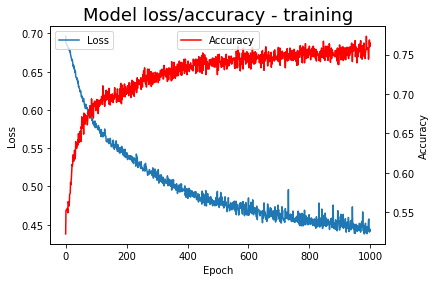

<Figure size 432x288 with 0 Axes>

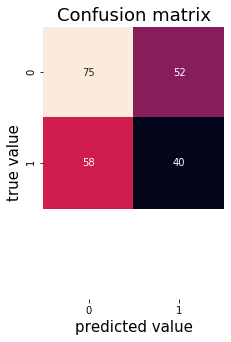

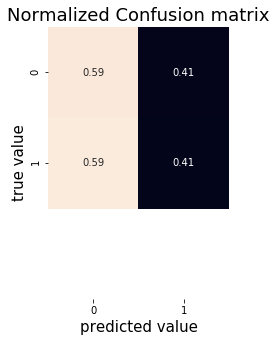

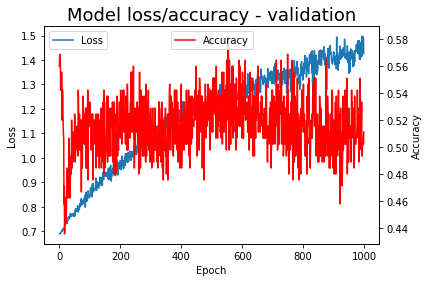

              precision    recall  f1-score   support

           0       0.56      0.59      0.58       127
           1       0.43      0.41      0.42        98

    accuracy                           0.51       225
   macro avg       0.50      0.50      0.50       225
weighted avg       0.51      0.51      0.51       225



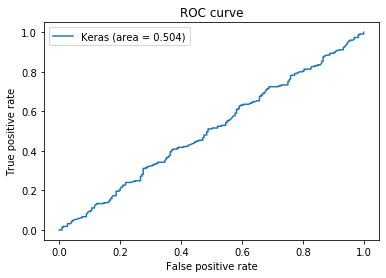

In [170]:
evaluate_mode(model)

***
## Regularization



    Let us see if a Dropout could lead to a better generalization. A dropout layer is added. Here we were experimenting with different amount of dropout layers and also adding dropout in the recurrent layer.
   


#### Let us define a new Recurrent Neural Network


Input shape 1274
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_61 (SimpleRNN)    (None, 16)                288       
_________________________________________________________________
dense_228 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_229 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_230 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_231 (Dense)            (None, 2)                 18        
Total params: 586
Trainable params: 586
Non-trainable params: 0
______________________________________

Epoch 75/200
 - 1s - loss: 0.6360 - accuracy: 0.6287 - val_loss: 0.7487 - val_accuracy: 0.5067
Epoch 76/200
 - 1s - loss: 0.6249 - accuracy: 0.6538 - val_loss: 0.7568 - val_accuracy: 0.5022
Epoch 77/200
 - 1s - loss: 0.6222 - accuracy: 0.6531 - val_loss: 0.7824 - val_accuracy: 0.5111
Epoch 78/200
 - 1s - loss: 0.6181 - accuracy: 0.6397 - val_loss: 0.7633 - val_accuracy: 0.5067
Epoch 79/200
 - 1s - loss: 0.6261 - accuracy: 0.6586 - val_loss: 0.7730 - val_accuracy: 0.4711
Epoch 80/200
 - 1s - loss: 0.6216 - accuracy: 0.6538 - val_loss: 0.7589 - val_accuracy: 0.4978
Epoch 81/200
 - 1s - loss: 0.6204 - accuracy: 0.6421 - val_loss: 0.7769 - val_accuracy: 0.4578
Epoch 82/200
 - 1s - loss: 0.6206 - accuracy: 0.6546 - val_loss: 0.7868 - val_accuracy: 0.4578
Epoch 83/200
 - 1s - loss: 0.6217 - accuracy: 0.6515 - val_loss: 0.7721 - val_accuracy: 0.4933
Epoch 84/200
 - 1s - loss: 0.6197 - accuracy: 0.6468 - val_loss: 0.7525 - val_accuracy: 0.4933
Epoch 85/200
 - 1s - loss: 0.6255 - accuracy: 0.64

Epoch 161/200
 - 1s - loss: 0.5916 - accuracy: 0.6797 - val_loss: 0.8482 - val_accuracy: 0.4889
Epoch 162/200
 - 1s - loss: 0.5847 - accuracy: 0.6852 - val_loss: 0.8441 - val_accuracy: 0.4400
Epoch 163/200
 - 1s - loss: 0.5851 - accuracy: 0.6829 - val_loss: 0.8483 - val_accuracy: 0.5067
Epoch 164/200
 - 1s - loss: 0.5937 - accuracy: 0.6868 - val_loss: 0.8414 - val_accuracy: 0.4756
Epoch 165/200
 - 1s - loss: 0.5890 - accuracy: 0.6868 - val_loss: 0.8441 - val_accuracy: 0.4800
Epoch 166/200
 - 1s - loss: 0.5925 - accuracy: 0.6797 - val_loss: 0.8622 - val_accuracy: 0.4844
Epoch 167/200
 - 1s - loss: 0.5816 - accuracy: 0.6954 - val_loss: 0.8516 - val_accuracy: 0.4800
Epoch 168/200
 - 1s - loss: 0.5823 - accuracy: 0.6860 - val_loss: 0.8842 - val_accuracy: 0.4756
Epoch 169/200
 - 1s - loss: 0.5976 - accuracy: 0.6719 - val_loss: 0.8463 - val_accuracy: 0.4711
Epoch 170/200
 - 1s - loss: 0.5873 - accuracy: 0.6947 - val_loss: 0.8559 - val_accuracy: 0.4578
Epoch 171/200
 - 1s - loss: 0.5870 - acc

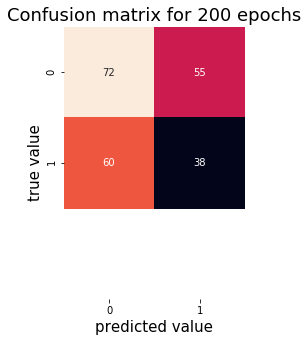

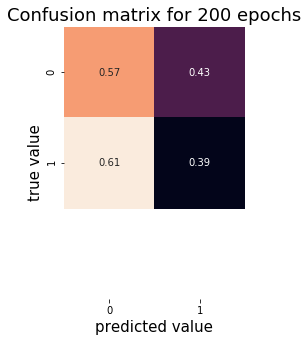

In [176]:


history = None


def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(SimpleRNN(16, dropout=0.1,  recurrent_dropout=0.2 input_shape=(None, 1)))
        #model.add(SimpleRNN(16, drinput_shape=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(8, activation='relu'))

            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
        #F1 score
        #error rate
        #ROC curve
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epoch's test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(200) 

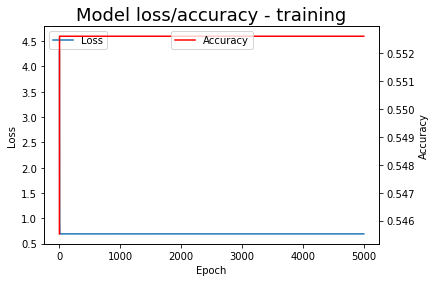

<Figure size 432x288 with 0 Axes>

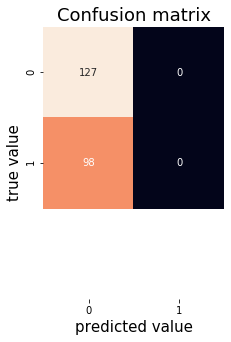

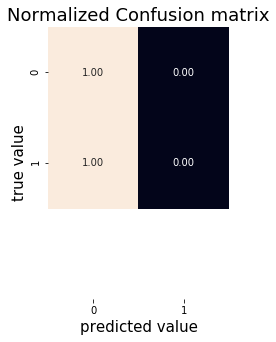

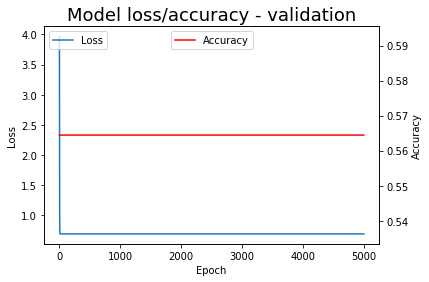

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       127
           1       0.00      0.00      0.00        98

    accuracy                           0.56       225
   macro avg       0.28      0.50      0.36       225
weighted avg       0.32      0.56      0.41       225



/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


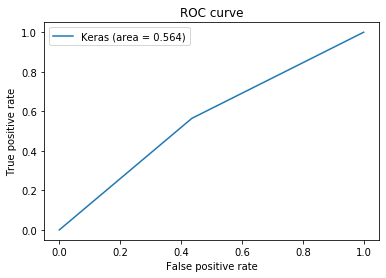

In [175]:
evaluate_mode(model)

It is remarkable that the Network can fit the training data. However, it seems like the sequnce of 7 daily price-changes cannot predict the 8th.


***

### L1 (Lasso)  and L2 (Ridge) regularizer

Let us try to add L1 and L2 Regulators.

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) will prevent overfitting by creating sparsity. It does so by penalizing different weights and pushing them near 0. When the connection is near 0 the network drops it. The idea is that it will eliminate features that do not help the network generalize.

L2 also keeps the weight small by penalizing the different weights, but it does so by forcing the weights into a gaussian distrbution. 

L1 and L2 can be added as kernel- or -activity regularizer in Keras

Input shape 1274
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 

Epoch 67/5000
 - 0s - loss: 0.6910 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 68/5000
 - 0s - loss: 0.6914 - accuracy: 0.5526 - val_loss: 0.6888 - val_accuracy: 0.5644
Epoch 69/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 70/5000
 - 0s - loss: 0.6914 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 71/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 72/5000
 - 0s - loss: 0.6914 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 73/5000
 - 0s - loss: 0.6912 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 74/5000
 - 0s - loss: 0.6913 - accuracy: 0.5526 - val_loss: 0.6888 - val_accuracy: 0.5644
Epoch 75/5000
 - 0s - loss: 0.6921 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 76/5000
 - 0s - loss: 0.6920 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 77/5000
 - 0s - loss: 0.6915 - acc

Epoch 152/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 153/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 154/5000
 - 0s - loss: 0.6913 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 155/5000
 - 0s - loss: 0.6918 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 156/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 157/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 158/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 159/5000
 - 0s - loss: 0.6912 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 160/5000
 - 0s - loss: 0.6918 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 161/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 162/5000
 - 1s - loss: 0

Epoch 237/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 238/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 239/5000
 - 0s - loss: 0.6914 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 240/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 241/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 242/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 243/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 244/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 245/5000
 - 0s - loss: 0.6914 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 246/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 247/5000
 - 0s - loss: 0

Epoch 322/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 323/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 324/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 325/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 326/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 327/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 328/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 329/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 330/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 331/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 332/5000
 - 0s - loss: 0

Epoch 407/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 408/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 409/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 410/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 411/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 412/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 413/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 414/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 415/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 416/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 417/5000
 - 0s - loss: 0

Epoch 492/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 493/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 494/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 495/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 496/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 497/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 498/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 499/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 500/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 501/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 502/5000
 - 0s - loss: 0

Epoch 577/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 578/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 579/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 580/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 581/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 582/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 583/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 584/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 585/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 586/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 587/5000
 - 0s - loss: 0

Epoch 662/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 663/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 664/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 665/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 666/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 667/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 668/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 669/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 670/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 671/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 672/5000
 - 0s - loss: 0

Epoch 747/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 748/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 749/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 750/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 751/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 752/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 753/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 754/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 755/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 756/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 757/5000
 - 0s - loss: 0

Epoch 832/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 833/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 834/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 835/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 836/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 837/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 838/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 839/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 840/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 841/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 842/5000
 - 0s - loss: 0

Epoch 917/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 918/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 919/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 920/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 921/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 922/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 923/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 924/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 925/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 926/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 927/5000
 - 0s - loss: 0

Epoch 1002/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1003/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1004/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1005/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1006/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1007/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1008/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1009/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1010/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1011/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1012/5000
 - 0

Epoch 1086/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1087/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1088/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1089/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1090/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1091/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1092/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1093/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1094/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1095/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1096/5000
 - 0

Epoch 1170/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1171/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1172/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1173/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1174/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1175/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1176/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1177/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1178/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1179/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1180/5000
 - 0

Epoch 1254/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1255/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1256/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1257/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1258/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1259/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1260/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1261/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1262/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1263/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1264/5000
 - 0

Epoch 1338/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1339/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1340/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1341/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1342/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1343/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1344/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1345/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1346/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1347/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1348/5000
 - 0

Epoch 1422/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1423/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1424/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1425/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1426/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1427/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1428/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1429/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1430/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1431/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1432/5000
 - 0

Epoch 1506/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1507/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1508/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1509/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1510/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1511/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1512/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1513/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1514/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1515/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1516/5000
 - 0

Epoch 1590/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1591/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1592/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1593/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1594/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1595/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1596/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1597/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1598/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1599/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1600/5000
 - 0

Epoch 1674/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1675/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1676/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1677/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1678/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1679/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1680/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1681/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1682/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1683/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1684/5000
 - 0

Epoch 1758/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1759/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1760/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1761/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1762/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1763/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1764/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1765/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1766/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1767/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1768/5000
 - 0

Epoch 1842/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1843/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1844/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1845/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1846/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1847/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 1848/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1849/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1850/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1851/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1852/5000
 - 0

Epoch 1926/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1927/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1928/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1929/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1930/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1931/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1932/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1933/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 1934/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1935/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 1936/5000
 - 0

Epoch 2010/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2011/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2012/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2013/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2014/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2015/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2016/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2017/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2018/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2019/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2020/5000
 - 0

Epoch 2094/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2095/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2096/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2097/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2098/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2099/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2100/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2101/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2102/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2103/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2104/5000
 - 0

Epoch 2178/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2179/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2180/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2181/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2182/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2183/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2184/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2185/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2186/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2187/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2188/5000
 - 0

Epoch 2262/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2263/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2264/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2265/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2266/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2267/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2268/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2269/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2270/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2271/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2272/5000
 - 1

Epoch 2346/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2347/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2348/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2349/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2350/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2351/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2352/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2353/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2354/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2355/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2356/5000
 - 0

Epoch 2430/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2431/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2432/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2433/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2434/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2435/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2436/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2437/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2438/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2439/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2440/5000
 - 0

Epoch 2514/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2515/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2516/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2517/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2518/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2519/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2520/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2521/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2522/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2523/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2524/5000
 - 0

Epoch 2598/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2599/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2600/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2601/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2602/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2603/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2604/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2605/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2606/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2607/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2608/5000
 - 0

Epoch 2682/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2683/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2684/5000
 - 1s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2685/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2686/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2687/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2688/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2689/5000
 - 1s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2690/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2691/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2692/5000
 - 0

Epoch 2766/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2767/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2768/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2769/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2770/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2771/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2772/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2773/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2774/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2775/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2776/5000
 - 0

Epoch 2850/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2851/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2852/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2853/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2854/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2855/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2856/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2857/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6892 - val_accuracy: 0.5644
Epoch 2858/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2859/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2860/5000
 - 0

Epoch 2934/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2935/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2936/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2937/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2938/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2939/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2940/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2941/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 2942/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 2943/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 2944/5000
 - 0

Epoch 3018/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3019/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3020/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3021/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3022/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3023/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3024/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3025/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3026/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3027/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3028/5000
 - 0

Epoch 3102/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3103/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3104/5000
 - 1s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3105/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3106/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3107/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3108/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3109/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3110/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3111/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3112/5000
 - 0

Epoch 3186/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3187/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3188/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3189/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3190/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3191/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3192/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3193/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3194/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3195/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3196/5000
 - 0

Epoch 3270/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3271/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3272/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3273/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3274/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3275/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3276/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3277/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3278/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3279/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3280/5000
 - 0

Epoch 3354/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3355/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3356/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3357/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3358/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3359/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3360/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3361/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3362/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3363/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3364/5000
 - 0

Epoch 3438/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3439/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3440/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3441/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3442/5000
 - 1s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3443/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3444/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3445/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3446/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3447/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3448/5000
 - 0

Epoch 3522/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3523/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3524/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3525/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3526/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3527/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3528/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3529/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3530/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3531/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3532/5000
 - 0

Epoch 3606/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3607/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3608/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3609/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3610/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3611/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3612/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3613/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3614/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3615/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3616/5000
 - 0

Epoch 3690/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3691/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3692/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3693/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3694/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3695/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3696/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3697/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3698/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3699/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3700/5000
 - 0

Epoch 3774/5000
 - 0s - loss: 0.6917 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3775/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3776/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3777/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3778/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3779/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3780/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3781/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3782/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3783/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3784/5000
 - 0

Epoch 3858/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3859/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3860/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3861/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3862/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3863/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3864/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3865/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3866/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3867/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3868/5000
 - 0

Epoch 3942/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3943/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3944/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3945/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3946/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3947/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 3948/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3949/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 3950/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3951/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 3952/5000
 - 0

Epoch 4026/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4027/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4028/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4029/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4030/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4031/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4032/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4033/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4034/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4035/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4036/5000
 - 0

Epoch 4110/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4111/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4112/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4113/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4114/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4115/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4116/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4117/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4118/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4119/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4120/5000
 - 0

Epoch 4194/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4195/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4196/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4197/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4198/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4199/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4200/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4201/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4202/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4203/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4204/5000
 - 0

Epoch 4278/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4279/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4280/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4281/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4282/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4283/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4284/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4285/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4286/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4287/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4288/5000
 - 0

Epoch 4362/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4363/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4364/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4365/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4366/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4367/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4368/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4369/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4370/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4371/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4372/5000
 - 0

Epoch 4446/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4447/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4448/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4449/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4450/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4451/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4452/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4453/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4454/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4455/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4456/5000
 - 0

Epoch 4530/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4531/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4532/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4533/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4534/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4535/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4536/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4537/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4538/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4539/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4540/5000
 - 0

Epoch 4614/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4615/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4616/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4617/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4618/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4619/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4620/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4621/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4622/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4623/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4624/5000
 - 0

Epoch 4698/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4699/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4700/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4701/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4702/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4703/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4704/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4705/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6892 - val_accuracy: 0.5644
Epoch 4706/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4707/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4708/5000
 - 0

Epoch 4782/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4783/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4784/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4785/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4786/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4787/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4788/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4789/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4790/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4791/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4792/5000
 - 0

Epoch 4866/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4867/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4868/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4869/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4870/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4871/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4872/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4873/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4874/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4875/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4876/5000
 - 0

Epoch 4950/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4951/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4952/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4953/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4954/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6891 - val_accuracy: 0.5644
Epoch 4955/5000
 - 0s - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5644
Epoch 4956/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4957/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4958/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4959/5000
 - 0s - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6890 - val_accuracy: 0.5644
Epoch 4960/5000
 - 0

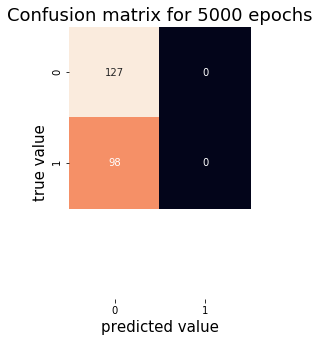

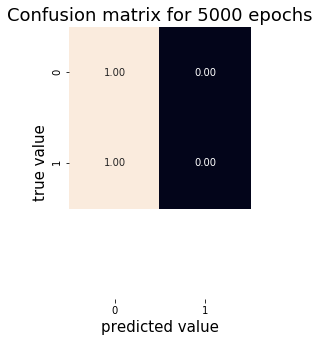

In [173]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(LSTM(64, input_shape=(None, 1),dropout=0.1, recurrent_dropout=0.1))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu',  activity_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), 
                        activity_regularizer=regularizers.l1(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
        model.add(Dropout(0.2))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
      
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(5000) 

The model could not fit the data even though we ran 5000 epochs. We saw that the model converged between a training loss of 7630 and 7631 after around 3600 epochs. We did not want to use a ** Early Stopping ** callback because we wanted to see if it could break out and eventually fit the data. 

## Only L1

In [174]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(LSTM(16, input_shape=(None, 1),dropout=0.1, recurrent_dropout=0.1))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
       # model.add(Dense(32, activation='relu'))
       # model.add(Dense(32, activation='relu'))

            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-12, patience=20, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, callbacks=[monitor], validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(400) 
#  That's most likely because it still tries to check for 'stable' label.}

Input shape 1274
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_223 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_224 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_225 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_226 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_227 (Dense)            (None, 3)                 99        
Total params: 22,243
Trainable params: 22,243
Non-trainable params: 0
________________________________

ValueError: Error when checking target: expected dense_227 to have shape (3,) but got array with shape (2,)

In [ ]:
evaluate_mode(model)

So it can not fit the traiing data with this L1 implementation. **As soon as the loss of the training starts to drop the validation loss is increasing.**

***

## Only L2

In [ ]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

#@{Article}
#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?

def create_and_run_RNN_L2(ep):
        model = Sequential()
  
        model.add(LSTM(64, input_shape=(None, 1),dropout=0.1))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.2))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       #@{Commented out code}
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
        #F1 score
        #error rate
        #ROC curve
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_L2(200) 


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


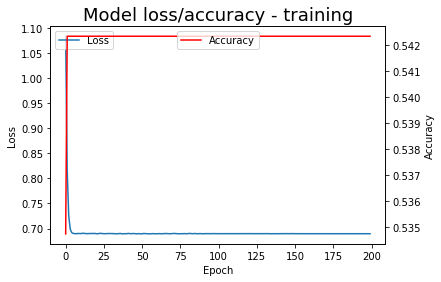

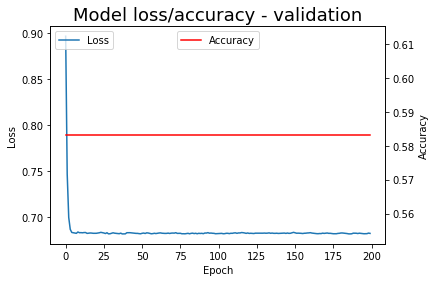

[[0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]
 [0.5431425  0.45685747]]
[1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       263
           1       0.00      0.00      0.00       188

    accuracy                           0.58       451
   macro avg       0.29      0.50      0.37       451
weighted avg       0.34      0.58      0.43       451



/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [147]:
evaluate_mode(model)

**So the model can not fit the training data with this L2 implementation. As soon as the loss of the training starts to drop the validation loss is increasing.**

## Different Sequence Length

## 3

In [ ]:
## 3

SEQUENCE_SIZE = 3
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)


history = None


#@{Article}
#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?

def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(SimpleRNN(64, input_shape=(None, 1)))
     
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
       #@{Commented out code}
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the default RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


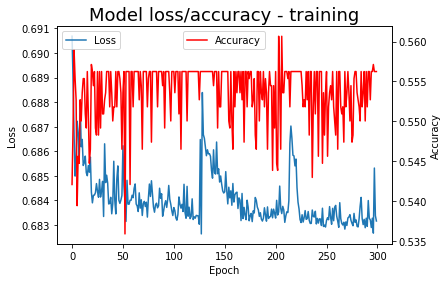

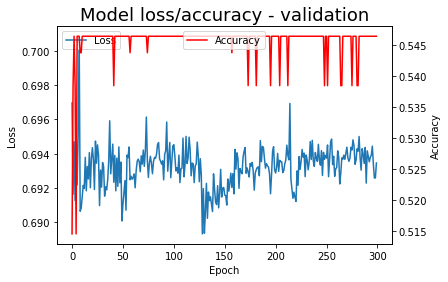

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 

/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


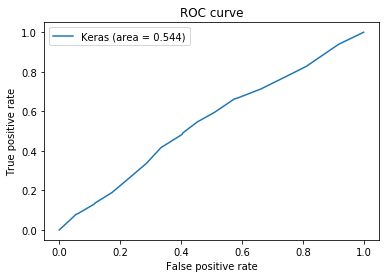

In [88]:
evaluate_mode(model)

## Sequence 14

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_80 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_81 (Dense)             (None, 2)                 66        
Total params: 8,482
Trainable params: 8,482
Non-trainable params: 0
_________________________________________________________________
Train on 1121 samples, validate on 374 samples
Epoch 1/200
 - 1s - loss: 0.6943 - accuracy: 0.5210 - val_loss: 0.6904

Epoch 77/200
 - 0s - loss: 0.1504 - accuracy: 0.9367 - val_loss: 2.6094 - val_accuracy: 0.4920
Epoch 78/200
 - 0s - loss: 0.1327 - accuracy: 0.9474 - val_loss: 2.4577 - val_accuracy: 0.4973
Epoch 79/200
 - 0s - loss: 0.1073 - accuracy: 0.9563 - val_loss: 2.4347 - val_accuracy: 0.5107
Epoch 80/200
 - 0s - loss: 0.1032 - accuracy: 0.9527 - val_loss: 2.5809 - val_accuracy: 0.5134
Epoch 81/200
 - 0s - loss: 0.1074 - accuracy: 0.9572 - val_loss: 2.4826 - val_accuracy: 0.5134
Epoch 82/200
 - 0s - loss: 0.1006 - accuracy: 0.9625 - val_loss: 2.5711 - val_accuracy: 0.5160
Epoch 83/200
 - 0s - loss: 0.0878 - accuracy: 0.9643 - val_loss: 2.6865 - val_accuracy: 0.5160
Epoch 84/200
 - 0s - loss: 0.0778 - accuracy: 0.9706 - val_loss: 2.5787 - val_accuracy: 0.5080
Epoch 85/200
 - 0s - loss: 0.0791 - accuracy: 0.9679 - val_loss: 2.5487 - val_accuracy: 0.5027
Epoch 86/200
 - 0s - loss: 0.1213 - accuracy: 0.9500 - val_loss: 2.6134 - val_accuracy: 0.5107
Epoch 87/200
 - 0s - loss: 0.1238 - accuracy: 0.94

Epoch 163/200
 - 0s - loss: 0.0874 - accuracy: 0.9581 - val_loss: 2.7640 - val_accuracy: 0.4947
Epoch 164/200
 - 0s - loss: 0.2983 - accuracy: 0.8947 - val_loss: 2.5374 - val_accuracy: 0.4759
Epoch 165/200
 - 0s - loss: 0.1333 - accuracy: 0.9420 - val_loss: 2.6144 - val_accuracy: 0.5187
Epoch 166/200
 - 0s - loss: 0.0817 - accuracy: 0.9581 - val_loss: 2.7381 - val_accuracy: 0.4973
Epoch 167/200
 - 0s - loss: 0.0557 - accuracy: 0.9741 - val_loss: 2.7845 - val_accuracy: 0.4866
Epoch 168/200
 - 0s - loss: 0.0503 - accuracy: 0.9679 - val_loss: 2.8886 - val_accuracy: 0.4813
Epoch 169/200
 - 0s - loss: 0.0599 - accuracy: 0.9706 - val_loss: 2.8656 - val_accuracy: 0.5000
Epoch 170/200
 - 0s - loss: 0.0491 - accuracy: 0.9679 - val_loss: 2.9235 - val_accuracy: 0.5027
Epoch 171/200
 - 0s - loss: 0.0472 - accuracy: 0.9715 - val_loss: 2.9444 - val_accuracy: 0.5027
Epoch 172/200
 - 0s - loss: 0.0480 - accuracy: 0.9670 - val_loss: 2.9878 - val_accuracy: 0.5080
Epoch 173/200
 - 0s - loss: 0.0453 - acc

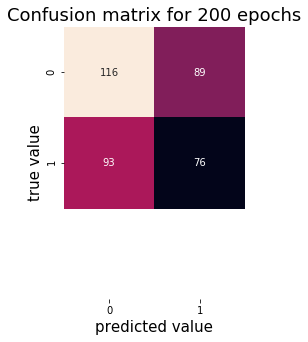

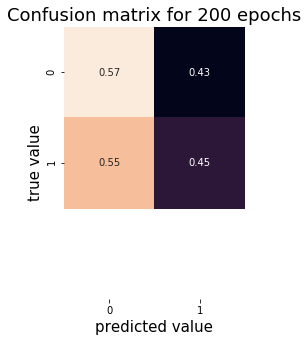

In [92]:
## 3

dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

SEQUENCE_SIZE = 14
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)






history = None

#@{Article.}

#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?

def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(SimpleRNN(64, input_shape=(None, 1)))
     
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
       #@{Commented out code}
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the default RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


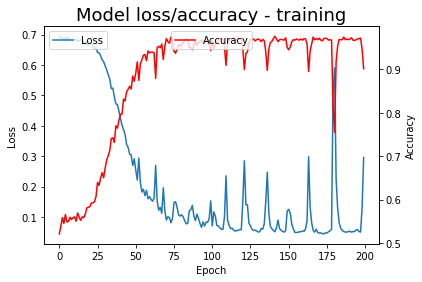

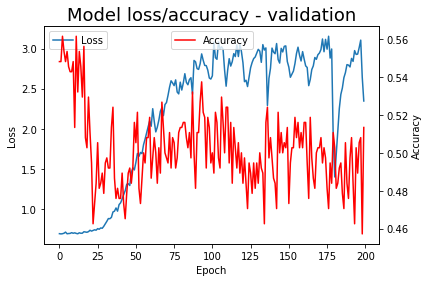

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

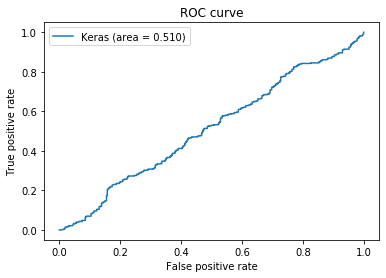

In [93]:
evaluate_mode(model)

## Overfits with larger sequence and 10 in batch size

### Sequence 5

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dense_82 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_84 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_85 (Dense)             (None, 2)                 66        
Total params: 8,482
Trainable params: 8,482
Non-trainable params: 0
_________________________________________________________________
Train on 1121 samples, validate on 374 samples
Epoch 1/200
 - 2s - loss: 0.6970 - accuracy: 0.5219 - val_loss: 0.6860

Epoch 77/200
 - 1s - loss: 0.1276 - accuracy: 0.9420 - val_loss: 2.7495 - val_accuracy: 0.4652
Epoch 78/200
 - 1s - loss: 0.1431 - accuracy: 0.9447 - val_loss: 2.7084 - val_accuracy: 0.4465
Epoch 79/200
 - 1s - loss: 0.1351 - accuracy: 0.9447 - val_loss: 2.7030 - val_accuracy: 0.4920
Epoch 80/200
 - 1s - loss: 0.1025 - accuracy: 0.9607 - val_loss: 2.6276 - val_accuracy: 0.4733
Epoch 81/200
 - 1s - loss: 0.0606 - accuracy: 0.9750 - val_loss: 2.8913 - val_accuracy: 0.4679
Epoch 82/200
 - 1s - loss: 0.0662 - accuracy: 0.9706 - val_loss: 2.8430 - val_accuracy: 0.4813
Epoch 83/200
 - 1s - loss: 0.0681 - accuracy: 0.9723 - val_loss: 3.0707 - val_accuracy: 0.4385
Epoch 84/200
 - 1s - loss: 0.0865 - accuracy: 0.9652 - val_loss: 2.8886 - val_accuracy: 0.4706
Epoch 85/200
 - 1s - loss: 0.4113 - accuracy: 0.8421 - val_loss: 2.1817 - val_accuracy: 0.4385
Epoch 86/200
 - 1s - loss: 0.1730 - accuracy: 0.9215 - val_loss: 2.3666 - val_accuracy: 0.4439
Epoch 87/200
 - 1s - loss: 0.0923 - accuracy: 0.95

Epoch 163/200
 - 1s - loss: 0.0521 - accuracy: 0.9768 - val_loss: 2.7164 - val_accuracy: 0.4572
Epoch 164/200
 - 1s - loss: 0.0448 - accuracy: 0.9732 - val_loss: 2.8153 - val_accuracy: 0.4572
Epoch 165/200
 - 1s - loss: 0.0403 - accuracy: 0.9786 - val_loss: 2.8863 - val_accuracy: 0.4545
Epoch 166/200
 - 1s - loss: 0.0388 - accuracy: 0.9759 - val_loss: 2.9821 - val_accuracy: 0.4572
Epoch 167/200
 - 1s - loss: 0.0909 - accuracy: 0.9572 - val_loss: 2.9169 - val_accuracy: 0.4813
Epoch 168/200
 - 1s - loss: 0.0926 - accuracy: 0.9625 - val_loss: 2.7489 - val_accuracy: 0.4813
Epoch 169/200
 - 1s - loss: 0.2442 - accuracy: 0.9090 - val_loss: 2.1474 - val_accuracy: 0.4947
Epoch 170/200
 - 1s - loss: 0.1496 - accuracy: 0.9304 - val_loss: 2.4558 - val_accuracy: 0.4840
Epoch 171/200
 - 1s - loss: 0.1120 - accuracy: 0.9625 - val_loss: 2.4152 - val_accuracy: 0.4759
Epoch 172/200
 - 1s - loss: 0.0625 - accuracy: 0.9715 - val_loss: 2.7038 - val_accuracy: 0.4626
Epoch 173/200
 - 1s - loss: 0.0462 - acc

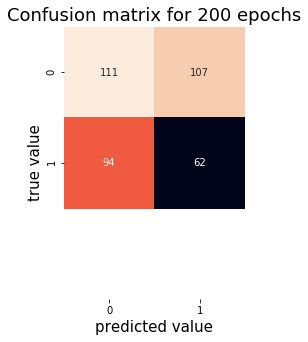

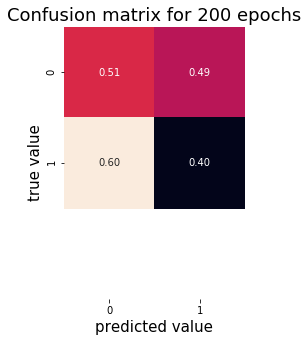

In [94]:
## 3

dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

SEQUENCE_SIZE = 14
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)






history = None


#@{Article.}
#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?

def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(LSTM(64, input_shape=(None, 1)))
     
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
       #@{Commented out code.}
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the defauly RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


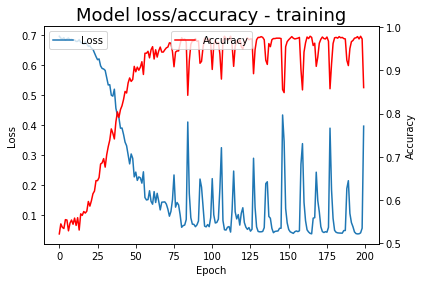

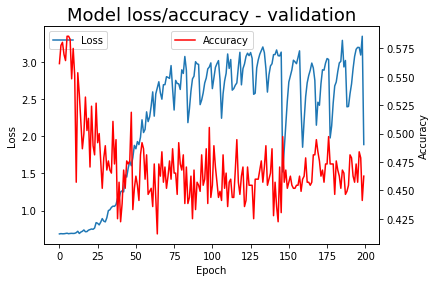

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

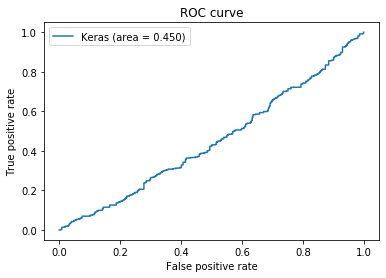

In [95]:
evaluate_mode(model)

## Result


    As mentioned before, the stock market has a complex pattern and there are billions of dollars put into the business of trying to predict where the stock will go the next day. Therefore, the market has no obvious function for the network to find. However, we had a very small dataset and a RNN of 7 days of daily price change.

    Also, the data set consisted of S&P 500 which is the 500 most traded stocks in the US. Therefore, it is most likely to correct itself in very unpredictable ways. The S&P 500 also consists of companies from a vast amount of different industries, which make the underlying price drivers very independent and not generalizable. 

    The features could also be enhanced by including technical indicators, such as volatilty, volume, and momentum indicators.

